# Hybrid Pumping Cell Characterization

This document is meant for conducting cell characterization measurements for the hybrid pumping set up.

In [1]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import one_ring.base.fitting_tools as fitt
import one_ring.daq.nidaqmx_tools as ndaq
import one_ring.base.signal_tools as sit

import one_ring.base.pandas_tools as pdt
import importlib
from one_ring.base.pint_units import ureg
import one_ring.base.h5py_tools as h5t
import scipy.constants
%matplotlib widget
import time as tm

import one_ring.daq.visa_instruments as nvisa
plt.style.use("dark_background")
import pandas as pd
from importlib import reload

In [2]:
#import nidaqmx as ni
import pyvisa as visa
import one_ring.daq.thorlabs as thor
import one_ring.daq.stanford_research_systems as srs

In [13]:
#useful constants
HH_Calib = 0.2*ureg.uT/(1*ureg.mA) #helmholtz coils
fluxgate_Calib = 100*ureg.uT/(10*ureg.V) #fluxgate 
outfname = "../data/hybrid_pumping.h5"
rad_e = scipy.constants.physical_constants['classical electron radius'][0] * ureg.m
c = scipy.constants.c*ureg.m/ureg.s
f_D1 = 1/3 #oscillator strength of d1 transition

{'slope': -0.02994121176448456, 'intercept': 389.74896028618315}

#from previous measurements
#freq_per_temp = -0.02994121176448456 * ureg.THz / ureg.delta_degC
#freq_per_temp_b = 389.74896028618315 * ureg.THz

{'slope': -0.02994121176448456, 'intercept': 389.74896028618315}

This document will 
1. Characterize the absorption sprectra of a cell (Elsa and Anna). The steps of this experiment include: heating up the cell to 150/190 degC, using the potassium laser aligned with the cell to a receiving powerimeter, sweeping the temperature to alter the frequency of the laser and use that to sweep across resonance

# Heating up the cell with DAQ

the function generator is outputing a sinewave at amplitude 11.1Vpp at 10 kHz. This is fed into the multiplier chip with a control signal coming from the PID temperature controller and and it sends the multiplied. Make sure to keep a careful watch on the amplitude with the oscilloscope and the frequency of the analogue output. The Vpp amplitude is about 79.6Vpp. I have 11 resistors in parallel that make about 8.6 ohm of resistance.

if using DAQ i use AO 6.54 V amplitude at 1 kHz

In [ ]:
f = 1000 * ureg.Hz
fs = 128 * f
samples_per_call = 5*fs.to(ureg.Hz).m
amp = 6.6 * ureg.V

sine_waveform = sit.SineGenerator(fs, amp.to(ureg.V).m, f, 0)

In [ ]:
ao_task = ndaq.AnalogOutputTask(fs, "CONTINUOUS")

In [ ]:
ao_task.configure_channels(1)

In [ ]:
ao_task.configure_finite_generation(next(sine_waveform))

In [ ]:
ao_task.start()

In [ ]:
ao_task.stop()

In [ ]:
ao_task.close()

# Magnetic Field Monitoring with Fluxgate

In [ ]:
FieldViewer.close()

In [ ]:
fs = 100 * ureg.Hz
dt = 1/fs
FieldViewer = ndaq.DAQViewer(dt,num_channels=2,height=5)

In [ ]:
FieldViewer.configure_channels()

In [ ]:
FieldViewer.display()
#100uT = 10V

In [ ]:
FieldViewer.get_data()['channel0'].mean() * ureg.V * fluxgate_Calib

# PMD100 Digital power measuring

In [ ]:
srs.SRS860LockIn.list_resources()

In [ ]:
pm_hot = thor.PM100DPowerMeter('USB0::0x1313::0x8078::P0049964::INSTR')
pm_ref = thor.PM100DPowerMeter('USB0::0x1313::0x8078::P0021883::INSTR')

pm_hot.num_average = 1000 #one second average
pm_ref.num_average = 1000

In [ ]:
select_wavelength = 770
pm_ref.wavelength = select_wavelength
pm_hot.wavelength = select_wavelength

In [ ]:
pm_ref.wavelength

In [ ]:
def measure_two_powers():
    hot = pm_hot.get_power().to(ureg.uW)
    ref = pm_ref.get_power().to(ureg.uW)
    return (hot,ref)

def measure_one_power():
    return pm_hot.get_power().to(ureg.uW)

In [ ]:
pm_hot.get_power().to(ureg.uW)

# WS-7 Wavemeter 

In [ ]:
import one_ring.daq.wlmConst as wlmConst

In [ ]:
import one_ring.daq.wlmData as wlmData

In [ ]:
import sys

In [ ]:
DLL_PATH = "wlmData.dll"
wlmData.LoadDLL(DLL_PATH)

In [ ]:
wlmData.dll.GetFrequency(0.0)

In [ ]:
wlmData.dll.GetPowerNum(1,0.0)

In [ ]:
def measure_powers_and_frequency():
    hot = pm_hot.get_power().to(ureg.uW)
    ref = pm_ref.get_power().to(ureg.uW)
    freq = wlmData.dll.GetFrequency(0.0) * ureg.THz
    wavemeter_p = wlmData.dll.GetPowerNum(1,0.0) * ureg.uW
    return hot, ref, freq, wavemeter_p

In [ ]:
measure_powers_and_frequency()

# Laser Power Monitoring

In [ ]:
fs = 234 * ureg.Hz
dt = 1/fs
DAQViewer = ndaq.DAQViewer(dt)

In [ ]:
DAQViewer.configure_channels()

In [ ]:
DAQViewer.display()

In [ ]:
DAQViewer.get_data().mean() * 41*ureg.mW/ 2 / ureg.V

In [ ]:
power_calib = 29*ureg.mW / (2*ureg.V)
#power_calib_2 = 28*ureg.mW / (2*ureg.V)

# Data Acquisition: K-Laser scan with Digital PMD100s

In [ ]:
laser.close()

In [ ]:
rm = visa.ResourceManager()
rm.list_resources()

In [ ]:
laser = srs.LDC501LaserController('ASRL14::INSTR')
laser.celsius_temperature

In [ ]:
fs = 10 * ureg.Hz
dur = 2 * ureg.s
fm = ndaq.FiniteMeasurement(dur.m, (fs * dur).m, num_channels=1)

In [ ]:
#fm.close()

In [ ]:
min_temp = ureg.Quantity(14, ureg.degC)
max_temp = ureg.Quantity(18, ureg.degC)

### acquire two power meters and wavemeter data 

In [50]:
min_temp = ureg.Quantity(14, ureg.degC)
max_temp = ureg.Quantity(18, ureg.degC)
step_size = 0.02 * ureg.delta_degC
num_steps = ( max_temp - min_temp ) / step_size
print(num_steps,(num_steps * 2 * ureg.s).to(ureg.min))

200.0 dimensionless 6.666666666666667 minute


In [ ]:
#digital acquisition for one powermeter
fscan_dig, out_queue_dig = laser.scan_temp_and_measure(measure_powers_and_frequency, max_temp, 0.02*ureg.delta_degC,
                            initial_temp=min_temp,initial_settle_time=30*ureg.s,
                                                 settle_time=2*ureg.s);

In [ ]:
results_dig= out_queue_dig.get_nowait() 

In [ ]:
a,b,c,d  = zip(*results_dig)
P_hot = np.array([])
P_ref = np.array([])
freq = np.array([])
P_wlm = np.array([])
for i,m in enumerate(a):
    P_hot = np.vstack(a) 
    P_ref = np.vstack(b) 
    freq = np.vstack(c) 
    P_wlm = np.vstack(d) 
P_hot = P_hot.flatten()
P_ref = P_ref.flatten()
freq = freq.flatten()
P_wlm = P_wlm.flatten()

### test visualize


In [ ]:
#calib_avg_test = freq.m * 0
#for j,m in enumerate(data_c):
#    calib_avg_test += trans_interp[j](freq) / ref_interp[j](freq)/(data_c.size)


fig, ax = plt.subplots()
ax.plot(freq, P_hot/P_ref)
#ax.plot(freq, P_ref)


### h5t.delete_dataset(outfname,"olaf_2025_07_28/K/absorption_3")

In [ ]:
h5t.get_children("hybrid_pumping.h5", "olaf_2025_07_29/K/")

In [ ]:
outfname = "hybrid_pumping.h5"
grp_name = "olaf_2025_07_31/K/calibration_curve_25"
#grp_name = "elsa_2025_07_11/absorption"
h5t.save_dataset(outfname, grp_name, "freq", freq)
h5t.save_dataset(outfname, grp_name, "hot", P_hot)
h5t.save_dataset(outfname, grp_name, "ref", P_ref)
h5t.save_dataset(outfname, grp_name, "wlm", P_wlm)
h5t.save_dataset(outfname, grp_name, "fscan_dig", fscan_dig)
metadata = {"probe_laser_current": laser.current_setpoint,
            "power_meter_head": "S121C and S120C",
            "power_meter_wavelength": pm_ref.wavelength, #not 830
            "cell_temperature": ureg.Quantity(22, ureg.degC),
            "initial_settling_time": 30*ureg.s,
            "settling_time_scan": 2*ureg.s,
            "misc_notes": "Calibration curve measurement. hot cell , TWO powermeters, and beam sampler. freq and power measurements with WS-7 too. same configuration as those made 1 days ago on MOnday"}
h5t.update_node_metadata(outfname, metadata, grp_name)

### acquire two power meter data

In [ ]:
#digital acquisition for two powermeters
fscan_dig, out_queue_dig = laser.scan_temp_and_measure(measure_two_powers, max_temp, 0.04*ureg.delta_degC,
                            initial_temp=min_temp,initial_settle_time=5*ureg.s,
                                                 settle_time=0.2*ureg.s);

In [ ]:
results_dig = out_queue_dig.get_nowait() 

In [ ]:
P_hot, P_ref = fm.unpack_averaged_measurements(results_dig)

### acquire one power meter data 

In [ ]:
measure_one_power()

In [ ]:
#digital acquisition for one powermeter
fscan_dig, out_queue_dig = laser.scan_temp_and_measure(measure_one_power, max_temp, 0.03*ureg.delta_degC,
                            initial_temp=min_temp,initial_settle_time=5*ureg.s,
                                                 settle_time=2.5*ureg.s);

In [ ]:
results_dig = out_queue_dig.get_nowait() 

In [ ]:
P_array = fm.unpack_averaged_measurements(results_dig)

In [ ]:
P_ref = P_array
P_ref

In [ ]:
P_hot = P_array
P_hot

### Absorption Powernormalizing Tools

In [ ]:
import scipy.optimize as optimize

def transmission_err(params):
    full_transmission = np.zeros(fscan_dig.m.size) + 1
    x_trans ,y_factor = params
    transformed_P_ref = P_ref.m * y_factor + x_trans
    normalized_transmission = transformed_P_ref/P_hot.m 
    error = np.sum((full_transmission - normalized_transmission)**2)
    return error

In [ ]:
initial_guess = [-19, 14.936437549819297]
result = optimize.minimize(transmission_err,initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

### Test visualizing 

In [ ]:
fig, axes = plt.subplots(figsize=(16,6),ncols=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]
x_range = freq

gain_normalizing = P_ref[0] / P_hot[0]
ax.scatter(x_range, P_hot   ,marker='.',label='hot',color='C0')
ax.scatter(x_range, P_ref / gain_normalizing,marker='.',label='ref',color='C1')
#ax.scatter(x_range, P_wlm / P_wlm[0] * P_hot[0],color='C2')
ax1.plot(x_range, (P_hot/P_ref )  ,marker='.',label='output',color='C2')
ax2.plot(fscan_dig, freq)

plt.suptitle('Test Visualization of Scan')
ax.set_title('Measured Powers')
ax.legend()
ax1.legend()
plt.show()

### Free Spectral Response

In [ ]:
deltaTemp= (14.1-13.78)*ureg.delta_degC

In [ ]:

deltaTemp= (14.0706-13.7166)*ureg.delta_degC

In [ ]:
deltaTemp = (14.3862-14.0706 + 14.0706-13.7166)/2*ureg.delta_degC

In [ ]:
deltaTemp = (4.33)*ureg.delta_degC

In [ ]:
freq_per_temp

In [ ]:
#free spectral range estimation
c = scipy.constants.c *ureg.m/ureg.s
#deltaTemp = (14.3862-14.0706 + 14.0706-13.7166)/2*ureg.delta_degC
#deltaFSR_lambda = (c / (deltaTemp * freq_per_temp + freq_per_temp_b )).to(ureg.nm)
cavity_length = (c / (deltaTemp * freq_per_temp))
cavity_length.to(ureg.mm)

### Save Data

In [ ]:
outfname = "hybrid_pumping.h5"
grp_name = "olaf_2025_07_18/normalization_test_4"
#grp_name = "elsa_2025_07_11/absorption"
h5t.save_dataset(outfname, grp_name, "temperature", fscan_dig)
h5t.save_dataset(outfname, grp_name, "hot", P_hot)
h5t.save_dataset(outfname, grp_name, "ref", P_ref)
metadata = {"probe_laser_current": 55*ureg.mA,
            "power_meter_head": "S121C",
            "power_meter_wavelength": pm_ref.wavelength, #not 830
            "cell_temperature": ureg.Quantity(30, ureg.degC),
            "misc_notes": "measurements made with two powermeters, and olaf (cold) cell and no cylindrical magnification. Just mirrors, beam sampler, and powermeters in output and after beam sampler. Shows meh power-matching"}
h5t.update_node_metadata(outfname, metadata, grp_name)

# Data Acquisiotion: K-Laser scan with Analogue PMD100s

In [ ]:
rm = visa.ResourceManager()
rm.list_resources()

In [ ]:
laser.close()

In [ ]:
laser = srs.LDC501LaserController('ASRL14::INSTR')
laser.celsius_temperature

In [ ]:
laser.inst.write('*IDN?')

In [ ]:
laser.inst.read()

In [ ]:
fs = 10 * ureg.Hz
dur = 2 * ureg.s
fm = ndaq.FiniteMeasurement(dur.m, (fs * dur).m, num_channels=1)

In [ ]:
#fm.configure_channels()

In [ ]:
min_temp = ureg.Quantity(13.55, ureg.degC)

max_temp = ureg.Quantity(17.55, ureg.degC)
#min_temp = ureg.Quantity(15.12, ureg.degC)
#max_temp = ureg.Quantity(16.22, ureg.degC)

In [ ]:
#digital acquisition
fscan_dig, out_queue_dig = laser.scan_temp_and_measure(measure_two_powers, max_temp, 0.5*ureg.delta_degC,
                            initial_temp=min_temp,initial_settle_time=4*ureg.s,
                                                 settle_time=1*ureg.s);

In [ ]:
#analogue acquisition
#fscan_dig, out_queue_dig = laser.scan_temp_and_measure(fm.measure_average, max_temp, 0.01*ureg.delta_degC,
#                            initial_temp=min_temp,initial_settle_time=8*ureg.s,
                                                 settle_time=1*ureg.s);

In [ ]:
results_dig = out_queue_dig.get_nowait() 

In [ ]:
#Vout_dig, Verr_dig = fm.unpack_averaged_measurements(results_dig)

In [ ]:
P_hot, P_ref = fm.unpack_averaged_measurements(results_dig)

In [ ]:
fig, axes = plt.subplots(figsize=(10,6),ncols=2)
ax = axes[0]
ax1 = axes[1]
calib1 = 29 * ureg.mW/(2*ureg.V)
#calib2 = 10 * ureg.mW / (2*ureg.V)
ax.plot(fscan_dig, calib1 * Vout_dig ,marker='.',label='output')
#ax.plot(fscan_dig, calib2 * Vout_dig[:, 1],marker='.',label='sampler')
#ax1.plot(fscan_dig,Vout_dig[:, 0]/Vout_dig[:, 1]* calib1 / calib2,marker='.',label='output') 
#data = (absorb_array_2 * power_calib_2).flatten().m
#data_err = absorb_err_2.flatten().m
#ax.errorbar(fscan_dig.m, data,yerr = data_err, label=/'hot atoms')
#ax.errorbar(fscan_dig.m, (noise_array*power_calib_2).flatten().m,yerr = noise_err.flatten().m,label='cold atoms')
ax.set_title('Potassium absorbtion')
ax.legend()
plt.show()

In [ ]:
outfname = "hybrid_pumping.h5"
grp_name = "elsa_2025_06_11/before_cell_3"
h5t.save_dataset(outfname, grp_name, "temperature", fscan_dig)
h5t.save_dataset(outfname, grp_name, "output", Vout_dig.flatten())
h5t.save_dataset(outfname, grp_name, "error", Verr_dig.flatten())
metadata = {"calib": (29)*ureg.mW,
            "laser_current": 99*ureg.mA,
            "power_meter_head": "S120VC",
            "power_meter_wavelength": 795*ureg.nm, #not 830
            "cell_temperature": ureg.Quantity(190, ureg.degC),
            "misc_notes": "without beam sampler"}
h5t.update_node_metadata(outfname, metadata, grp_name)

In [ ]:
##### for beam splitter data taking

fig, axes = plt.subplots(figsize=(10,6),ncols=2)
ax = axes[0]
ax1 = axes[1]
calib1 = 2.9 * ureg.mW/(2*ureg.V)
calib2 = 10 * ureg.mW / (2*ureg.V)
ax.plot(fscan_dig, calib1 * Vout_dig[:, 0],marker='.',label='output')
ax.plot(fscan_dig, calib2 * Vout_dig[:, 1],marker='.',label='sampler')
ax1.plot(fscan_dig,Vout_dig[:, 0]/Vout_dig[:, 1]* calib1 / calib2,marker='.',label='output') 
#data = (absorb_array_2 * power_calib_2).flatten().m
#data_err = absorb_err_2.flatten().m
#ax.errorbar(fscan_dig.m, data,yerr = data_err, label=/'hot atoms')
#ax.errorbar(fscan_dig.m, (noise_array*power_calib_2).flatten().m,yerr = noise_err.flatten().m,label='cold atoms')
ax.set_title('Potassium absorbtion')
ax.legend()
plt.show()

In [ ]:
#h5t.delete_dataset(outfname, grp_name)
Vout_dig[:, 0] #output
Vout_dig[:,1]; #beam sampler

In [ ]:
outfname = "hybrid_pumping.h5"
grp_name = "elsa_2025_06_10/large_scan"
h5t.save_dataset(outfname, grp_name, "temperature", fscan_dig)
h5t.save_dataset(outfname, grp_name, "cell_output", Vout_dig[:, 0].flatten())
h5t.save_dataset(outfname, grp_name, "sampler_output", Vout_dig[:, 1].flatten())
h5t.save_dataset(outfname, grp_name, "cell_error", Verr_dig[:, 0].flatten())
h5t.save_dataset(outfname, grp_name, "sampler_error", Verr_dig[:, 1].flatten())
metadata = {"calib": (2.9, 10)*ureg.mW,
            "laser_current": 80*ureg.mA,
            "power_meter_head": "S120VC and S120C",
            "power_meter_wavelength": 795*ureg.nm, #not 830
            "cell_temperature": ureg.Quantity(190, ureg.degC),
            "misc_notes": ""}
h5t.update_node_metadata(outfname, metadata, grp_name)

# Data Acquisition: Rb Scan with digital PMD100s

In [ ]:
#RESET ARRAY
P_hot_array = np.array([]) * ureg.uW
P_ref_array = np.array([]) * ureg.uW


In [ ]:
x_range = np.arange(1,100,1) * ureg.V
x_range

In [ ]:
rb_pmd100 = measure_two_powers()
P_hot_array= np.append(P_hot_array, rb_pmd100[0])
P_ref_array= np.append(P_ref_array, rb_pmd100[1])

In [ ]:
x_range, P_hot_array, P_ref_array.shape

In [ ]:
x_range.shape

In [ ]:
P_hot_array = np.array([]) * ureg.uW
P_ref_array = np.array([]) * ureg.uW
for i in np.arange(0,99,1):  
    rb_pmd100 = measure_two_powers()
    P_hot_array= np.append(P_hot_array, rb_pmd100[0])
    P_ref_array= np.append(P_ref_array, rb_pmd100[1])
    print(i)
    tm.sleep(0.2)
    

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
gain_calib = P_hot_array[0]/ P_ref_array[0]
ax.plot(x_range.m, P_hot_array.m, label='hot')
ax.plot(x_range.m, (P_ref_array*gain_calib), label='ref')
ax2.plot(x_range.m, P_hot_array/(P_ref_array*gain_calib), color='C3' )

ax.legend()
plt.show()

In [ ]:
outfname = "hybrid_pumping.h5"
grp_name = "olaf_2025_07_14/Rb/absorption_2"
#grp_name = "elsa_2025_07_11/absorption"
h5t.save_dataset(outfname, grp_name, "piezo", x_range)
h5t.save_dataset(outfname, grp_name, "P_hot", P_hot_array)
h5t.save_dataset(outfname, grp_name, "P_ref", P_ref_array)
metadata = {"laser_current": 57*ureg.mA,
            "power_meter_head": "S120VC and S121VC",
            "power_meter_wavelength": 421*ureg.nm, #not 830
            "cell_temperature": ureg.Quantity(190, ureg.degC),
            "misc_notes": "with beam sampler"}
h5t.update_node_metadata(outfname, metadata, grp_name)

# Data Acquistion: Rb Laser sweep

In [4]:
import one_ring.daq.sacher_lasertechnik as sl


In [5]:
reload(sl);

In [44]:
rm = visa.ResourceManager()
rm.list_resources()

('ASRL1::INSTR', 'ASRL4::INSTR')

In [45]:
Rb_laser = sl.PilotPCLaserController('ASRL4::INSTR')

In [46]:
Rb_laser.identity

'Sacher Lasertechnik, PilotPC 500, SN2498016, SW V8.00 HW V9.0 PZ V8.0'

In [ ]:
#Rb_laser.inst.write(':Piezo:ENA')

In [72]:
Rb_laser.query(':Piezo:ENA?')

'ON'

In [64]:
Rb_laser.write("system:echo off")
Rb_laser.write("system:acknowledge off")

In [ ]:
Rb_laser.inst.read()

In [ ]:
#Rb_laser.inst.read()

In [ ]:
Rb_laser.close()

In [73]:
Rb_laser.query('*IDN?')

'Sacher Lasertechnik, PilotPC 500, SN2498016, SW V8.00 HW V9.0 PZ V8.0'

In [ ]:
piezo_frequency_calib = ((710.180 - 710.775)*ureg.THz / (10*ureg.V)).to(ureg.GHz/ureg.V)

In [ ]:
piezo_resonance_rb =  0 * ureg.V

In [ ]:
half_range = (350*ureg.GHz / -piezo_frequency_calib / 2).round(3)

In [ ]:
final_piezo = (piezo_resonance_rb + half_range).round(3)
final_piezo

In [ ]:
initial_piezo = (piezo_resonance_rb - half_range).round(3)
initial_piezo

In [ ]:
Rb_laser.piezo_setpoint

In [ ]:
Rb_laser.piezo_setpoint = -1

In [ ]:
#Rb_laser.piezo_ramp(1*ureg.V, 1*ureg.min,execute=True)

In [89]:
Rb_laser.piezo_setpoint = -5 + 0.02*4

In [ ]:
Rb_laser.temperature_setpoint = 11

In [ ]:
Rb_laser.celsius_temperature

In [ ]:
Rb_laser.current_setpoint = 50*ureg.mA

In [ ]:
Rb_laser.current_setpoint

In [ ]:
Rb_laser.piezo_ramp(5*ureg.V, 20*ureg.s,step_size=0.05,execute=False);

In [82]:
-5 + 0.02*1

-4.98

In [85]:
#np.linspace(-5,5, 500)

In [ ]:
((np.linspace(-5,5, 500).size*ureg.s) * 4).to(ureg.min)

In [74]:
vscan, measure_out = Rb_laser.scan_piezo_offset_and_measure(measure_powers_and_frequency,
                                       5,
                                       0.02*ureg.V,
                                       initial_voltage=-5,
                                       initial_settle_time=60*ureg.s,
                                       settle_time=3*ureg.s)

NameError: name 'measure_powers_and_frequency' is not defined

In [ ]:
results_dig= measure_out.get_nowait() 

In [ ]:
P_hot_i, P_ref_i, freq_i, P_wlm_i  = zip(*results_dig)
P_hot = np.array([])
P_ref = np.array([])
freq = np.array([])
P_wlm = np.array([])

P_hot = np.vstack(P_hot_i) 
P_ref = np.vstack(P_ref_i) 
freq = np.vstack(freq_i) 
P_wlm = np.vstack(P_wlm_i) 

P_hot = P_hot.flatten()
P_ref = P_ref.flatten()
freq = freq.flatten()
P_wlm = P_wlm.flatten()

In [ ]:
fig, axes = plt.subplots(ncols=2,figsize=(12,5))
ax0 = axes[0]
ax1 = axes[1]
x_range = freq

mask = (x_range.m > 700) * (x_range.m < 720)

ax0.plot(x_range[mask], P_hot[mask],marker='.')
ax0.plot(x_range, P_ref,marker='.')
ax1.plot(x_range[mask], P_hot[mask]/P_ref[mask] ,marker='.')

#ax0.set_xlim(710.84,711.18)

#ax1.set_xlim(710.84,711.18)

In [ ]:
Rb_laser.inst.write(':Piezo:FREQ:GEN 0')

In [ ]:
Rb_laser.query(':Piezo:FREQ:GEN?')

In [ ]:
Rb_laser.query('Piezo:FREQ:GEN:MOD?')

In [ ]:
Rb_laser.inst.write(':Piezo:FREQ:AMP 1mV')

In [ ]:
Rb_laser.current_setpoint

In [ ]:
h5t.save_dataset(outfname, grp_name, "Piezo", vscan)

In [ ]:
outfname = "hybrid_pumping.h5"
grp_name = "olaf_2025_07_25/rb/hot_scan"
h5t.save_dataset(outfname, grp_name, "P_hot", P_hot)
h5t.save_dataset(outfname, grp_name, "P_ref", P_ref)
h5t.save_dataset(outfname, grp_name, "freq", freq)
h5t.save_dataset(outfname, grp_name, "P_wlm", P_wlm)

metadata = {"calib": np.nan,
            "laser_current": Rb_laser.current_setpoint,
            "power_meter_head": "S120C and S121C",
            "power_meter_wavelength": 421*ureg.nm, #not 830
            "cell_temperature": ureg.Quantity(190, ureg.degC),
            "laser_temp": Rb_laser.celsius_temperature,
            "piezo scan": (-5,0.02,5),
            "misc_notes": "Rb scan with digital piezo scanning. coarse full spectrum scan"}
h5t.update_node_metadata(outfname, metadata, grp_name)

# View Data

### Absorption power normalizing tools

In [ ]:
import scipy.optimize as optimize

#P_ref = (sample_output*sample_output_calib).to(ureg.uW)
#P_hot = (cell_output*cell_output_calib).to(ureg.uW)
x_axis = temperature

def transmission_err(params):
    full_transmission = np.zeros(x_axis.m.size) + 1
    x_trans ,y_factor = params
    transformed_P_ref = P_ref.m * y_factor + x_trans
    normalized_transmission = transformed_P_ref/P_hot.m 
    error = np.sum((full_transmission - normalized_transmission)**2)
    return error

In [ ]:
initial_guess = [-19, 14.936437549819297]
result = optimize.minimize(transmission_err,initial_guess)
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

##  Temperature to Frequency calibration

data was lifted from "fit_absorption_spectrum.ipynb" where i think temperature scans and frequency measurements were made for a potassium laser 

In [ ]:
{'slope': -0.02994121176448456, 'intercept': 389.74896028618315}

freq_per_temp = -0.02994121176448456 * ureg.THz / ureg.delta_degC
freq_per_temp_b = 389.74896028618315 * ureg.THz

# Archive of Previous Measurements

## Plotting absorption 09/06/2025

In [ ]:
cold_data = h5t.load_group(outfname, "elsa_2025_06_09/cold_scan")
hot_data = h5t.load_group(outfname, "elsa_2025_06_09/hot_scan") 
temperature = cold_data['temperature'].m * ureg.delta_degC
hot_scan = hot_data['transmitted_power']
cold_scan = cold_data['transmitted_power']
freq = temperature * freq_per_temp + freq_per_temp_b
xaxis = freq

normalized_transmission = hot_scan*power_calib / (cold_scan*power_calib)

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

K_d1_transition = 389.286058716 * ureg.THz

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(temperature.m, normalized_transmission.m)
fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (hot_scan*power_calib).m, label='hot atoms')

ax.plot(temperature.m, (cold_scan*power_calib).m,label='cold atoms')
#ax2.axvline(K_d1_transition.m)
ax2.plot(temperature.m,  normalized_transmission.m,".-", alpha=0.5)

ax.set_title('Potassium absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.show()

In [ ]:
fit_result.fit_parameters

In [ ]:
elsa_PN2 = 50*ureg.torr
elsa_PHe = 500*ureg.torr

In [ ]:
FWHM = fit_result.fit_parameters['HWHM'] * 2

In [ ]:
#Helium has a resonance broadening coefficient of about 17MHz/Torr, we would estimate the broadening due to Helium pressure to be 
(19.6*ureg.MHz/ureg.torr*elsa_PHe).to(ureg.GHz)

In [ ]:
#the FWHM of the measured data is below
(FWHM*ureg.THz).to(ureg.GHz)

In [ ]:
#Helium can cause a shift in the resonance 
(2.54*ureg.MHz/ureg.torr * elsa_PHe).to(ureg.GHz)

In [ ]:
#the resonance shift of measured data is below
(K_d1_transition - fit_result.fit_parameters['f0']*ureg.THz).to(ureg.GHz)

## Plotting K-Absorption using beam sampler 09/06/2025

In [ ]:
h5t.get_children(outfname, "elsa_2025_06_09")

In [ ]:
full_scan = h5t.load_group(outfname, "elsa_2025_06_09/full_scan")
before_cell = h5t.load_group(outfname, "elsa_2025_06_09/before_cell")
full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_09/full_scan")




temperature = full_scan['temperature'].m * ureg.delta_degC
powerimeter = full_scan['powerimeter']
cell_output = full_scan['powerimeter'].reshape([150,2])[:,0]
cell_output_calib = 29 * ureg.mW / (2*ureg.V)
sample_output = full_scan['powerimeter'].reshape([150,2])[:,1]
sample_output_calib = 10 * ureg.mW / (2*ureg.V)
#K_d1_transition = 389.286058716 * ureg.THz
#freq = temperature * freq_per_temp + freq_per_temp_b
#xaxis = freq

normalized_transmission = cell_output*cell_output_calib / (sample_output*sample_output_calib)

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
#fit_result = abs_fitter.fit(temperature.m, normalized_transmission.m)
#fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (cell_output*cell_output_calib).m, label='cell_output')

ax.plot(temperature.m, (sample_output*sample_output_calib).m,label='sample beam output')
#ax2.axvline(K_d1_transition.m)
ax2.plot(temperature.m,  normalized_transmission.m,".-", alpha=0.5)

ax.set_title('Potassium absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('full scan')
plt.show()

In [ ]:
full_scan = h5t.load_group(outfname, "elsa_2025_06_09/off_resonance")
before_cell = h5t.load_group(outfname, "elsa_2025_06_09/before_cell")
full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_09/full_scan")

gain_factor = 1.25


temperature = full_scan['temperature'].m * ureg.delta_degC
powerimeter = full_scan['powerimeter']
cell_output = full_scan['powerimeter'].reshape([100,2])[:,0]
cell_output_calib = 29 * ureg.mW / (2*ureg.V)
sample_output = full_scan['powerimeter'].reshape([100,2])[:,1]
sample_output_calib = 10 * ureg.mW / (2*ureg.V)
#K_d1_transition = 389.286058716 * ureg.THz
#freq = temperature * freq_per_temp + freq_per_temp_b
#xaxis = freq

normalized_transmission = cell_output*cell_output_calib*gain_factor / (sample_output*sample_output_calib)

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
#fit_result = abs_fitter.fit(temperature.m, normalized_transmission.m)
#fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (cell_output*cell_output_calib*gain_factor).m, label='cell_output')

ax.plot(temperature.m, (sample_output*sample_output_calib).m,label='sample beam output')
#ax2.axvline(K_d1_transition.m)
ax2.plot(temperature.m,  normalized_transmission.m,".-", alpha=0.5)

ax.set_title('Potassium absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('off resonance')
plt.show()

## Plotting absorption with beam sampler 10/06/20205


In [ ]:
h5t.get_children(outfname, "elsa_2025_06_10")

In [ ]:
full_scan = h5t.load_group(outfname, "elsa_2025_06_10/on_resonance")
#before_cell = h5t.load_group(outfname, "elsa_2025_06_10/before_cell")
full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_10/on_resonance")

temperature = full_scan['temperature'].m * ureg.delta_degC
cell_output = full_scan['cell_output']
cell_output_calib = 2.9 * ureg.mW / (2*ureg.V)
sample_output = full_scan['sampler_output']
sample_output_calib = 10 * ureg.mW / (2*ureg.V)
#K_d1_transition = 389.286058716 * ureg.THz
#freq = temperature * freq_per_temp + freq_per_temp_b
#xaxis = freq

normalized_transmission = cell_output*cell_output_calib / (sample_output*sample_output_calib*1.5)

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(temperature.m, normalized_transmission.m)
fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (cell_output*cell_output_calib).m, label='cell_output')

ax.plot(temperature.m, ((sample_output*sample_output_calib).m*1.5-1),label='sample beam output')
#ax2.axvline(K_d1_transition.m)
ax2.plot(temperature.m,  normalized_transmission.m,".-", alpha=0.5)

ax.set_title('Potassium absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('full scan')
plt.show()

In [ ]:
full_scan = h5t.load_group(outfname, "elsa_2025_06_10/off_resonance")
#before_cell = h5t.load_group(outfname, "elsa_2025_06_10/before_cell")
full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_10/off_resonance")

temperature = full_scan['temperature'].m * ureg.delta_degC
cell_output = full_scan['cell_output']
cell_output_calib = 2.9 * ureg.mW / (2*ureg.V)
sample_output = full_scan['sampler_output']
sample_output_calib = 10 * ureg.mW / (2*ureg.V)
#K_d1_transition = 389.286058716 * ureg.THz
#freq = temperature * freq_per_temp + freq_per_temp_b
#xaxis = freq

normalized_transmission = cell_output*cell_output_calib / (sample_output*sample_output_calib)

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
#fit_result = abs_fitter.fit(temperature.m, normalized_transmission.m)
#fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (cell_output*cell_output_calib).m, label='cell_output')

ax.plot(temperature.m, (sample_output*sample_output_calib).m,label='sample beam output')
#ax2.axvline(K_d1_transition.m)
ax2.plot(temperature.m,  normalized_transmission.m,".-", alpha=0.5)

ax.set_title('Potassium absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('full scan')
plt.show()

In [ ]:
full_scan = h5t.load_group(outfname, "elsa_2025_06_10/large_scan")
#before_cell = h5t.load_group(outfname, "elsa_2025_06_10/before_cell")
full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_10/large_scan")


temperature = full_scan['temperature'].m * ureg.delta_degC
cell_output = full_scan['cell_output']
cell_output_calib = 2.9 * ureg.mW / (2*ureg.V)
sample_output = full_scan['sampler_output']
sample_output_calib = 10 * ureg.mW / (2*ureg.V)
#K_d1_transition = 389.286058716 * ureg.THz
#freq = temperature * freq_per_temp + freq_per_temp_b
#xaxis = freq

normalized_transmission = cell_output*cell_output_calib / (sample_output*sample_output_calib)

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(temperature.m, normalized_transmission.m)
fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (cell_output*cell_output_calib ).m, label='cell_output')

ax.plot(temperature.m, (sample_output*sample_output_calib).m + 0.27,label='sample beam output')
#ax2.axvline(K_d1_transition.m)
ax2.plot(temperature.m,  normalized_transmission.m,".-", alpha=0.5)

ax.set_title('Potassium absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('full scan')
plt.show()

In [ ]:
freq_per_temp = -0.02994121176448456 * ureg.THz / ureg.delta_degC
freq_per_temp_b = 389.74896028618315 * ureg.THz

In [ ]:
#free spectral range estimation
c = scipy.constants.c *ureg.m/ureg.s
deltaTemp = (17.223-16.972)*ureg.delta_degC
#deltaFSR_lambda = (c / (deltaTemp * freq_per_temp + freq_per_temp_b )).to(ureg.nm)
cavity_length = (c / (deltaTemp * freq_per_temp))
cavity_length.to(ureg.mm)

In [ ]:
#free spectral range estimation
c = scipy.constants.c *ureg.m/ureg.s
deltaTemp = (20.43-17.13)*ureg.delta_degC
#deltaFSR_lambda = (c / (deltaTemp * freq_per_temp + freq_per_temp_b )).to(ureg.nm)
cavity_length = (c / (deltaTemp * freq_per_temp))
cavity_length.to(ureg.mm)

In [ ]:
(deltaTemp * freq_per_temp).to(ureg.GHz)

## Absorption measurment, but with Qiandong's method 10/06/2025

In [ ]:
before_cell = h5t.load_group(outfname, "elsa_2025_06_10/before_cell")
after_cell = h5t.load_group(outfname, "elsa_2025_06_10/after_cell")
#before_cell = h5t.load_group(outfname, "elsa_2025_06_10/before_cell")
full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_10/large_scan")

temperature = after_cell['temperature'].m * ureg.delta_degC
cell_output = after_cell['output']
cell_output_calib = 2.9 * ureg.mW / (2*ureg.V)
sample_output = before_cell['output']
sample_output_calib = 29 * ureg.mW / (2*ureg.V)
#K_d1_transition = 389.286058716 * ureg.THz
#freq = temperature * freq_per_temp + freq_per_temp_b
#xaxis = freq

normalized_transmission = cell_output*cell_output_calib / (sample_output*sample_output_calib)

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(temperature.m, normalized_transmission.m)
fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (cell_output*cell_output_calib).m, label='cell_output')

ax.plot(temperature.m, (sample_output*sample_output_calib).m,label='sample beam output')
#ax2.axvline(K_d1_transition.m)
ax2.plot(temperature.m,  normalized_transmission.m,".-", alpha=0.5)

ax.set_title('Potassium absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('full scan')
plt.show()

## K scan #2 ELSA  11/06/2025 

In [ ]:
full_scan_md

In [ ]:
before_cell = h5t.load_group(outfname, "elsa_2025_06_11/before_cell_3")
after_cell = h5t.load_group(outfname, "elsa_2025_06_11/after_cell_3")
#before_cell = h5t.load_group(outfname, "elsa_2025_06_10/before_cell")
full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_11/after_cell_3")

temperature = after_cell['temperature'].m * ureg.delta_degC
cell_output = after_cell['output']
cell_output_calib = 2.9 * ureg.mW / (2*ureg.V)
sample_output = before_cell['output'] 
sample_output_calib = 29 * ureg.mW / (2*ureg.V)
gain_calib = (sample_output[0]*sample_output_calib)/(cell_output[0]*cell_output_calib)

normalized_transmission = (cell_output*cell_output_calib / (sample_output*sample_output_calib)*gain_calib)
logged_transmission = -np.log(normalized_transmission)
transmission_resonance = normalized_transmission.min() / normalized_transmission.max()
fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(temperature.m, logged_transmission.m,guess = [0.07,15.55,0.144,0.05])
fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (cell_output*cell_output_calib*gain_calib).m, label='cell_output')
ax.plot(temperature.m, (sample_output*sample_output_calib).m,label='sample beam output')

ax.set_title('Potassium Transmission (normalized)')
ax2.set_title('Absorption')
ax.legend()
plt.suptitle('Elsa 11/06/2025 K-Scan')
plt.show()

In [ ]:
#DENSITY CALCULATION
HWHM_temp = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.delta_degC)
HWHM_freq = HWHM_temp * freq_per_temp
c = scipy.constants.c*ureg.m/ureg.s
cross_section_on_resonance = c*rad_e*f_D1/ (HWHM_freq) * -1 #fixing signage
cross_section_on_resonance.to(ureg.cm**2)
L = 1 * ureg.cm
#absorbance_resonance = -np.log(normalized_transmission.min()/normalized_transmission[0])
absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM']
density_K = absorbance_resonance / (L * cross_section_on_resonance)
density_K.to(1/ureg.cm**3)
"{:.3e} 1/cm^3".format(density_K.to(1/ureg.cm**3).m)

## Rb scan ELSA 13/06/2025 [BAD]

In [ ]:
data= h5t.load_group(outfname, "elsa_2025_06_13/rb/fine_scan")
data_md = h5t.get_node_metadata(outfname, "elsa_2025_06_13/rb/fine_scan")


x_axis = data['Rb_wavelength']
after_cell = data['after_cell'] * data_md['calib_after']
before_cell = data['before_cell'] * data_md['calib_before']
after_cell_err = data['after_cell_err'] * data_md['calib_after']
before_cell_err = data['before_cell_err'] * data_md['calib_before']

normalized_transmission = after_cell / before_cell
#normalized_transmission = -np.log(after_cell / before_cell)

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(x_axis.m, normalized_transmission.m)
fit_result.plot_fit(ax=ax2)
ax2.plot(x_axis.m, normalized_transmission.m,alpha=0.3)
ax.errorbar(x_axis.m, after_cell.m, yerr = after_cell_err, label='after cell')

ax.errorbar(x_axis.m, before_cell.m, yerr = before_cell_err, label='before cell')

ax.set_title('Rb absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('full scan')
plt.show()

## Rb scan ELSA 20/06/20205 [BAD]

In [ ]:
data= h5t.load_group(outfname, "elsa_2025_06_20/rb/scan")
data_md = h5t.get_node_metadata(outfname, "elsa_2025_06_20/rb/scan")


voltage_offset_out = data['voltage_offset_out']
voltage_offset_ref = data['voltage_offset_ref']
wavelength_out = data['wavelength_out']
wavelength_ref = data['wavelength_ref']
power_out = data['power_out']
power_ref = data['power_ref']

data_dict = {
    "voltage_offset_out": voltage_offset_out,
    "voltage_offset_ref": voltage_offset_ref,
    "wavelength_out": wavelength_out,
    "wavelength_ref": wavelength_ref,
    "power_out": power_out,
    "power_ref": power_ref,
}
data_df = pd.DataFrame(data_dict).sort_values('wavelength_out')

voltage_offset_out = data_df['voltage_offset_out'].to_numpy() * ureg.V
voltage_offset_ref = data_df['voltage_offset_ref'].to_numpy() * ureg.V
wavelength_out = data_df['wavelength_out'].to_numpy() * ureg.nm
wavelength_ref = data_df['wavelength_ref'].to_numpy() * ureg.nm
power_out = data_df['power_out'].to_numpy() * ureg.uW
power_ref = data_df['power_ref'].to_numpy() * ureg.uW


normalized_transmission = power_out / power_ref
#normalized_transmission = -np.log(after_cell / before_cell)

fig, axes = plt.subplots(figsize=(9,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

ax.plot( wavelength_out.m, power_out.m)
ax.plot(wavelength_ref.m, power_ref.m)

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(wavelength_out.m, normalized_transmission.m)
fit_result.plot_fit(ax=ax2,fkwargs={"alpha":0.4})
ax2.scatter(wavelength_out.m, normalized_transmission.m,alpha=0.3)
#ax.errorbar(wavelength_out.m, after_cell.m, yerr = after_cell_err, label='after cell')

#ax.errorbar(wavelength_out.m, before_cell.m, yerr = before_cell_err, label='before cell')

x=np.linspace(421.48,421.65,100)
y=fit_result.fit_parameters['A'] *fit_result.fit_parameters['HWHM']/(( x - fit_result.fit_parameters['f0'])**2 + fit_result.fit_parameters['HWHM']**2) + fit_result.fit_parameters['Offset']
ax2.plot(x,y,alpha=0.8)
ax.set_title('Rb absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('full scan')
plt.show()

In [ ]:
fit_result.fit_parameters

## Rb scan OLAF 14/07/2025 [BAD]

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

data = h5t.load_group(outfname, "olaf_2025_07_14/Rb/absorption")
P_hot = data['P_hot']
P_ref = data['P_ref']
x_range = data['piezo']
ax2 = ax.twinx()
gain_calib = P_hot[0]/ P_ref[0]
ax.plot(x_range.m, P_hot.m, label='hot')
ax.plot(x_range.m, (P_ref*gain_calib), label='ref')
ax2.plot(x_range.m, P_hot/(P_ref*gain_calib), color='C3' )

ax.legend()
plt.show()

## Rb Scan OLAF 14/07/2025 [BAD]

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

data = h5t.load_group(outfname, "olaf_2025_07_14/Rb/absorption_2")
P_hot = data['P_hot']
P_ref = data['P_ref']
x_range = data['piezo']
ax2 = ax.twinx()
gain_calib = P_hot[0]/ P_ref[0]
ax.plot(x_range.m, P_hot.m, label='hot')
ax.plot(x_range.m, (P_ref*gain_calib), label='ref')
ax2.plot(x_range.m, P_hot/(P_ref*gain_calib), color='C3' )

ax.legend()
plt.show()

## Rb scan ELSA 13/06/2025 [BAD]

In [ ]:
data= h5t.load_group(outfname, "elsa_2025_06_13/rb/coarse_scan")
data_md = h5t.get_node_metadata(outfname, "elsa_2025_06_13/rb/coarse_scan")

x_axis = data['Rb_wavelength']
after_cell = data['after_cell'] * data_md['calib_after']
before_cell = data['before_cell'] * data_md['calib_before'] 

normalized_transmission = after_cell / before_cell * before_cell[0] / after_cell[0]

#normalized_transmission = -np.log(cell_output*cell_output_calib / (sample_output*sample_output_calib))

fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(x_axis.m, normalized_transmission.m)
fit_result.plot_fit(ax=ax2)
ax.plot(x_axis.m, after_cell.m, label='after cell')

ax.plot(x_axis.m, before_cell.m,label='before cell')

ax.set_title('Rb absorbtion')
ax2.set_title('Normalized Transmission')
ax.legend()
plt.suptitle('full scan')
plt.show()

# K scan ELSA  11/06/2025 [GOOD]

In [ ]:
before_cell = h5t.load_group(outfname, "elsa_2025_06_11/before_cell")
after_cell = h5t.load_group(outfname, "elsa_2025_06_11/after_cell")
full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_11/after_cell")

temperature = after_cell['temperature'].m * ureg.delta_degC
cell_output = after_cell['output']
cell_output_calib = 2.9 * ureg.mW / (2*ureg.V)
sample_output = before_cell['output']
sample_output_calib = 29 * ureg.mW / (2*ureg.V)

normalized_transmission = (cell_output*cell_output_calib / (sample_output*sample_output_calib*0.05207809 - 19.0465*ureg.uW)) 
#adjustment factures are for bringing gain levels so that offresonance provides 100% transmission
logged_transmission = -np.log(normalized_transmission)
fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(temperature.m, logged_transmission.m,guess = [0.07,15.55,0.144,0.05])
fit_result.plot_fit(ax=ax2)
ax.plot(temperature.m, (cell_output*cell_output_calib).m, label='cell_output')
ax.plot(temperature.m, (sample_output*sample_output_calib*0.05207809 - 19.0465*ureg.uW).m,label='sample beam output')

ax.set_title('Potassium normalized transmission')
ax2.set_title('Absorption')
ax.legend()
plt.suptitle('Elsa 2025/06/11 K-scan')
plt.show()

In [ ]:
#DENSITY CALCULATION
HWHM_temp = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.delta_degC)
HWHM_freq = HWHM_temp * freq_per_temp
c = scipy.constants.c*ureg.m/ureg.s
cross_section_on_resonance = c*rad_e*f_D1/ (HWHM_freq) * -1 #fixing signage
cross_section_on_resonance.to(ureg.cm**2)
L = 1 * ureg.cm
#absorbance_resonance = -np.log(normalized_transmission.min()/normalized_transmission[0])
absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM']
density_K = absorbance_resonance / (L * cross_section_on_resonance)
density_K.to(1/ureg.cm**3)
"{:.3e} 1/cm^3".format(density_K.to(1/ureg.cm**3).m)

# K scan ELSA  07/11/2025 [MEH]

In [ ]:
h5t.get_children(outfname,"elsa_2025_07_11")

In [ ]:
h5t.get_node_metadata(outfname, "elsa_2025_07_11/absorption")

In [ ]:
data = h5t.load_group(outfname, "elsa_2025_07_11/absorption")
#full_scan_md = h5t.get_node_metadata(outfname, "elsa_2025_06_10/large_scan")

P_hot = data['error']
P_ref = data['output']
x_range = data['temperature']
gain_calib = P_hot[0] / P_ref[0]
normalized_transmission = (P_ref/P_hot*gain_calib) 
#adjustment factures are for bringing gain levels so that offresonance provides 100% transmission
logged_transmission = -np.log(normalized_transmission)
fig, axes = plt.subplots(figsize=(15,6), ncols=2)
ax = axes[0]
ax2 =axes[1]

abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(x_range.m, logged_transmission.m,guess = [0.07,15.55,0.144,0.05])
fit_result.plot_fit(ax=ax2)
ax.plot(x_range.m, (P_hot).m, label='cell_output')
ax.plot(x_range.m, (P_ref*gain_calib).m,label='sample beam output')

ax.set_title('Potassium normalized transmission')
ax2.set_title('absorption')
ax.legend()
plt.suptitle('Elsa 2025/07/11 K-scan')
plt.show()

In [ ]:
#DENSITY CALCULATION
HWHM_temp = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.delta_degC)
HWHM_freq = HWHM_temp * freq_per_temp
cross_section_on_resonance = c*rad_e*f_D1/ (HWHM_freq) * -1 #fixing signage
cross_section_on_resonance.to(ureg.cm**2)
L = 1 * ureg.cm
#absorbance_resonance = -np.log(normalized_transmission.min()/normalized_transmission[0])
absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM']
density_K = absorbance_resonance / (L * cross_section_on_resonance)
density_K.to(1/ureg.cm**3)
"{:.3e} 1/cm^3".format(density_K.to(1/ureg.cm**3).m)

# K Scan - NO CELL cell and trying to get good off-resonance NOrmalization

In [ ]:
h5t.get_children(outfname,"nocell_2025_07_17")

In [ ]:
fig, axes = plt.subplots(figsize=(14,6),ncols=2)
ax = axes[0]
ax1 = axes[1]

data = h5t.load_group(outfname, "nocell_2025_07_17/normalization_test")
P_hot = data['hot']
P_ref = data['ref']
x_range = data['temperature']

gain_normalizing = P_ref[0] / P_hot[0]
ax.plot(x_range, P_hot   ,marker='.',label='output power',color='C0')
ax.plot(x_range, P_ref / gain_normalizing,marker='.',label='reference power (gain adjusted)',color='C1')
ax1.plot(x_range, (P_hot/P_ref * gain_normalizing )  ,marker='.',label='normalized transmission',color='C2')

plt.suptitle('Testing how well the reference power matches output power over a scan (NO CELL)')
ax.set_title('Measured Powers')
ax.legend()
ax.set_xlabel('laser temperature')
ax1.set_xlabel('laser temperature')
ax.set_ylabel('Power [uW]')
ax1.set_ylabel('normalized transmission')
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(14,6),ncols=2)
ax = axes[0]
ax1 = axes[1]

data = h5t.load_group(outfname, "nocell_2025_07_17/normalization_test_2")
P_hot = data['hot']
P_ref = data['ref']
x_range = data['temperature']

gain_normalizing = P_ref[0] / P_hot[0]
ax.plot(x_range, P_hot   ,marker='.',label='output power',color='C0')
ax.plot(x_range, P_ref / gain_normalizing,marker='.',label='reference power (gain adjusted)',color='C1')

ax1.plot(x_range, (P_hot/P_ref * gain_normalizing )  ,marker='.',label='normalized transmission',color='C2')

plt.suptitle('Testing how well the reference power matches output power over a scan (COLD CELL)')
ax.set_title('Measured Powers')
ax.legend()
ax.set_xlabel('laser temperature')
ax1.set_xlabel('laser temperature')
ax.set_ylabel('Power [uW]')
ax1.set_ylabel('normalized transmission')
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(14,6),ncols=2)
ax = axes[0]
ax1 = axes[1]

data = h5t.load_group(outfname, "nocell_2025_07_17/normalization_test_3")
P_hot = data['hot']
P_ref = data['ref']
x_range = data['temperature']

gain_normalizing = P_ref[0] / P_hot[0]
ax.plot(x_range, P_hot   ,marker='.',label='output power',color='C0')
ax.plot(x_range, P_ref / gain_normalizing,marker='.',label='reference power (gain adjusted)',color='C1')
ax1.plot(x_range, (P_hot/P_ref * gain_normalizing )  ,marker='.',label='normalized transmission',color='C2')

plt.suptitle('Testing how well the reference power matches output power over a scan (COLD CELL AND TWO POWERMETERS)')
ax.set_title('Measured Powers')
ax.legend()
ax.set_xlabel('laser temperature')
ax1.set_xlabel('laser temperature')
ax.set_ylabel('Power [uW]')
ax1.set_ylabel('normalized transmission')
plt.show()

# K_Scan OLAF or maybe no cell i dont recall Calibration Curve Measurement, Determining best Settling Time

These measurements scan using diff settling times to see whether the laser's frequency is settling fst enough in time for measurement. 2s seems sufficiently smooth and 4s is only a  little bit better so I'll just go for something like 2.5 seconds settling time. 1s and less is definitely too fast though

In [ ]:
data = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_1")
P_hot1 = data['hot']
P_ref1 = data['ref']
x_range1 = data['freq']
fscan_dig1 = data['fscan_dig']

data = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_2")
P_hot2 = data['hot']
P_ref2 = data['ref']
x_range2 = data['freq']
fscan_dig2 = data['fscan_dig']

data = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_3")
P_hot3 = data['hot']
P_ref3 = data['ref']
x_range3 = data['freq']
fscan_dig3 = data['fscan_dig']

In [ ]:
fig, axes = plt.subplots(figsize=(16,6),ncols=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]

gain_normalizing1 = P_ref1[0] / P_hot1[0]
ax.plot(x_range1, P_hot1   ,marker='.',label='hot',color='C0')
ax.plot(x_range1, P_ref1 / gain_normalizing1 , marker='.',label='ref',color='C1')
ax1.plot(x_range1, (P_hot1/P_ref1 * gain_normalizing1 )  ,marker='.',label='normalized, 1s settling time',color='C2')
ax2.plot(fscan_dig1, x_range1,label='1s')

ax1.plot(x_range2, (P_hot2 / P_ref2 * P_ref2[0] / P_hot2[0]), marker = '.', label='2s settling time', color = 'C3')
ax1.plot(x_range3, (P_hot3 / P_ref3 * P_ref3[0] / P_hot3[0]), marker = '.', label='4s settling time', color = 'C4')

ax2.plot(fscan_dig2, x_range2, label='2s')
ax2.plot(fscan_dig3, x_range3,label='3s')

plt.suptitle('Test Visualization of Scan')
ax.set_title('Measured Powers')
ax.legend()
ax1.legend()
ax2.legend()
plt.show()

# K-Scan OLAF cold, [BAD] - because I didn't have a cell inside i think

In [ ]:
data = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_8")
P_hot1 = data['hot']
P_ref1 = data['ref']
x_range1 = data['freq']
fscan_dig1 = data['fscan_dig']

#calibration_curve_test = P_hot1/P_ref1

In [ ]:
fig, axes = plt.subplots(figsize=(16,6),ncols=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]

gain_normalizing1 = P_ref1[0] / P_hot1[0]
ax.plot(x_range1, P_hot1   ,marker='.',label='hot',color='C0')
ax.plot(x_range1, P_ref1 / gain_normalizing1 , marker='.',label='ref',color='C1')
ax1.plot(x_range1, (P_hot1/P_ref1  )  ,marker='.',label='normalized, 1s settling time',color='C2')
ax2.plot(fscan_dig1, x_range1,label='1s')

plt.suptitle('Test Visualization of Scan')
ax.set_title('Measured Powers')
ax.legend()
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
#loading up 6 scans of calibration data
data4 = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_4")
data5 = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_5")
data6 = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_6")
data7 = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_7")
data8 = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_8")
data9 = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_9")

In [ ]:
#making an average claibration curve of those cold scans loaded
avg_Phot = np.zeros(data4['hot'].size)
avg_Pref = np.zeros(data4['ref'].size)
for i,m in enumerate(data4['hot']):
    phot_points = np.array( [data4['hot'][i].m, data5['hot'][i].m, data6['hot'][i].m, data7['hot'][i].m, data8['hot'][i].m, data9['hot'][i].m])
    avg_Phot[i] = np.mean(phot_points)
    
    pref_points = np.array( [data4['ref'][i].m, data5['ref'][i].m, data6['ref'][i].m, data7['ref'][i].m, data8['ref'][i].m, data9['ref'][i].m])
    avg_Pref[i] = np.mean(pref_points)
    
calibration_curve = avg_Phot/avg_Pref 

In [ ]:
#testing the calibration curve data against a cold scan. Noramlization curve should be around 1%
data = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_9")
P_hot = data['hot']
P_ref = data['ref']
x_range = data['freq']
fscan_dig = data['fscan_dig']

In [ ]:
fig, axes = plt.subplots(figsize=(16,6),ncols=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]

gain_normalizing1 = avg_Pref[0] / avg_Phot[0]
ax.plot(x_range, avg_Phot   ,marker='.',label='hot',color='C0')
ax.plot(x_range, avg_Pref/gain_normalizing1  , marker='.',label='ref',color='C1')
ax1.plot(x_range, (P_hot1/P_ref1 /calibration_curve)  ,marker='.',label='normalized, 1s settling time',color='C2')
ax2.plot(fscan_dig, x_range,label='1s')

plt.suptitle('Test Visualization of Scan')
ax.set_title('Measured Powers')
ax.legend()
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
data = h5t.load_group(outfname, "olaf_2025_07_18/calibration_curve_8")
P_hot = data['hot']
P_ref = data['ref']
x_range = data['freq']
fscan_dig = data['fscan_dig']

In [ ]:
fig, axes = plt.subplots(figsize=(16,6),ncols=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]

gain_normalizing1 = P_ref[0] / P_hot[0]
ax.plot(x_range, P_hot   ,marker='.',label='hot',color='C0')
ax.plot(x_range, P_ref / gain_normalizing , marker='.',label='ref',color='C1')
ax1.plot(x_range, (P_hot/P_ref / calibration_curve )  ,marker='.',label='normalized, 1s settling time',color='C2')
ax2.plot(fscan_dig, x_range,label='1s')

plt.suptitle('Test Visualization of Scan')
ax.set_title('Measured Powers')
ax.legend()
ax1.legend()
ax2.legend()
plt.show()

# K-Scan ELSA Cold using a calibration curve [OK]

In [14]:
outfname

'../data/hybrid_pumping.h5'

In [16]:
#loading up 6 scans of calibration data
data1 = h5t.load_group(outfname, "elsa_2025_07_21/calibration_curve_1")
data2 = h5t.load_group(outfname, "elsa_2025_07_21/calibration_curve_2")
data3 = h5t.load_group(outfname, "elsa_2025_07_21/calibration_curve_3")
data4 = h5t.load_group(outfname, "elsa_2025_07_21/calibration_curve_4")
data5 = h5t.load_group(outfname, "elsa_2025_07_21/calibration_curve_5")

data_c = np.array([data1,data2,data3,data4,data5])

In [17]:
h5t.get_node_metadata(outfname, "elsa_2025_07_21/calibration_curve_5")

{'misc_notes': 'Calibration curve measurement. Cold cell ELSA, two powermeters, and beam sampler. freq and power measurements with WS-7 too.',
 'power_meter_head': 'S121C and S120C',
 'cell_temperature': <Quantity(190, 'degree_Celsius')>,
 'power_meter_wavelength': <Quantity(770, 'nanometer')>,
 'probe_laser_current': <Quantity(55, 'milliampere')>,
 'settling_time_scan': <Quantity(2.5, 'second')>}

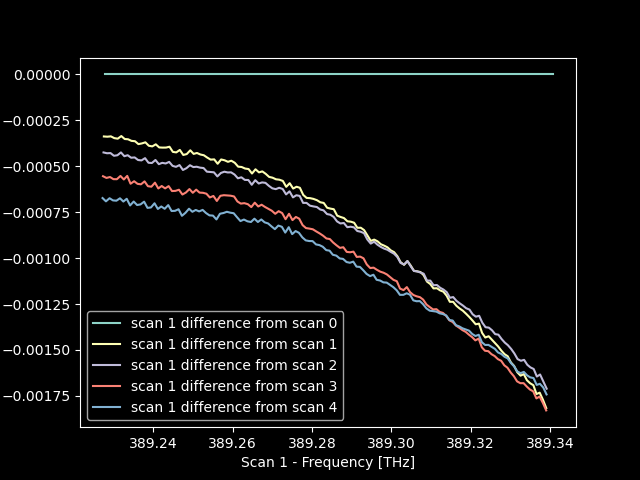

In [18]:
fig, ax = plt.subplots()
for i,m in enumerate(data_c):
    ax.plot(m['freq'].m,m['freq'].m-data1['freq'].m,label='scan 1 difference from scan ' + str(i))
ax.set_ylabel('Frequency [THz]')
ax.set_xlabel('Scan 1 - Frequency [THz]')
ax.legend()
plt.show()

In [19]:
f_min = np.max([data1['freq'][-1].m,data2['freq'][-1].m,data3['freq'][-1].m,data4['freq'][-1].m,data5['freq'][-1].m]) * ureg.THz
f_max = np.min([data1['freq'][0].m,data2['freq'][0].m,data3['freq'][0].m,data4['freq'][0].m,data5['freq'][0].m]) * ureg.THz
#f_min = h5t.load_group(outfname,"elsa_2025_07_21/absorption_4")['freq'][-1].m
#f_max = h5t.load_group(outfname,"elsa_2025_07_21/absorption_4")['freq'][0].m
num_steps = 133
common_freq_array = np.linspace(f_min, f_max, num_steps)

ref_interp = [0,0,0,0,0]
trans_interp = [0,0,0,0,0]
for i, data_set in enumerate(data_c):
    ref_interp[i] = scipy.interpolate.interp1d(data_set['freq'].m, data_set['ref'].m, kind = 'linear')
    trans_interp[i] = scipy.interpolate.interp1d(data_set['freq'].m, data_set['hot'].m, kind = 'linear')

C:\Users\labuser_L213\miniforge3\envs\one_ring\lib\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
C:\Users\labuser_L213\miniforge3\envs\one_ring\lib\site-packages\scipy\_lib\_util.py:321: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = toarray(a)


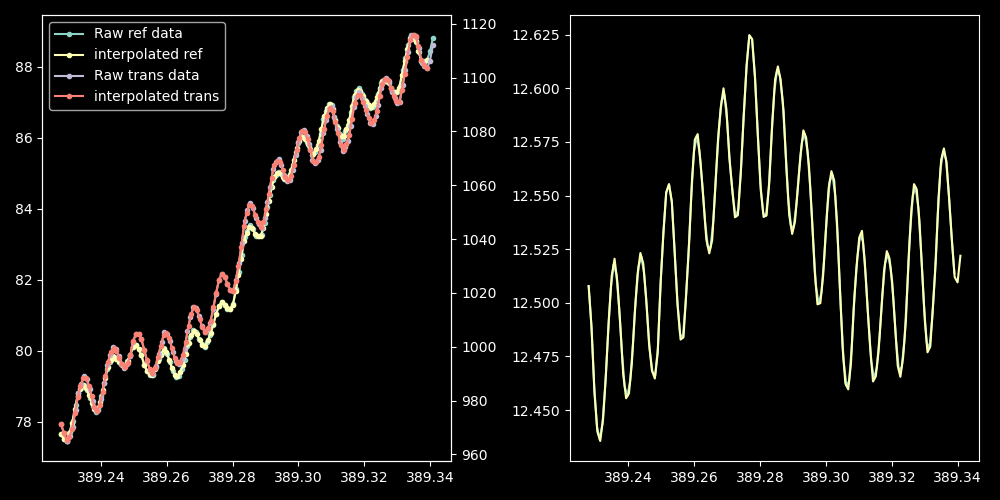

In [20]:
fig, axes = plt.subplots(figsize=(10,5),ncols=2)
ax0 = axes[0]
ax01 = ax0.twinx()
ax1 = axes[1]
l1 = ax0.plot(data1['freq'],data1['ref'], color='C0',label='Raw ref data',marker='.')
l2 = ax0.plot(common_freq_array, ref_interp[0](common_freq_array),color='C1', label='interpolated ref',marker='.')
l3 = ax01.plot(data1['freq'],data1['hot'], color='C2',label='Raw trans data',marker='.')
l4 = ax01.plot(common_freq_array, trans_interp[0](common_freq_array),color='C3', label='interpolated trans',marker='.')
lns = l1 + l2 + l3 + l4
ax0.legend(lns, [l.get_label() for l in lns], loc=0 )

ln5 = ax1.plot(common_freq_array, trans_interp[0](common_freq_array) / ref_interp[0](common_freq_array), label='interpolated calibration')
ln6 = ax1.plot(data1['freq'], data1['hot']/data1['ref'], label='raw calibration')
plt.tight_layout()
plt.show()

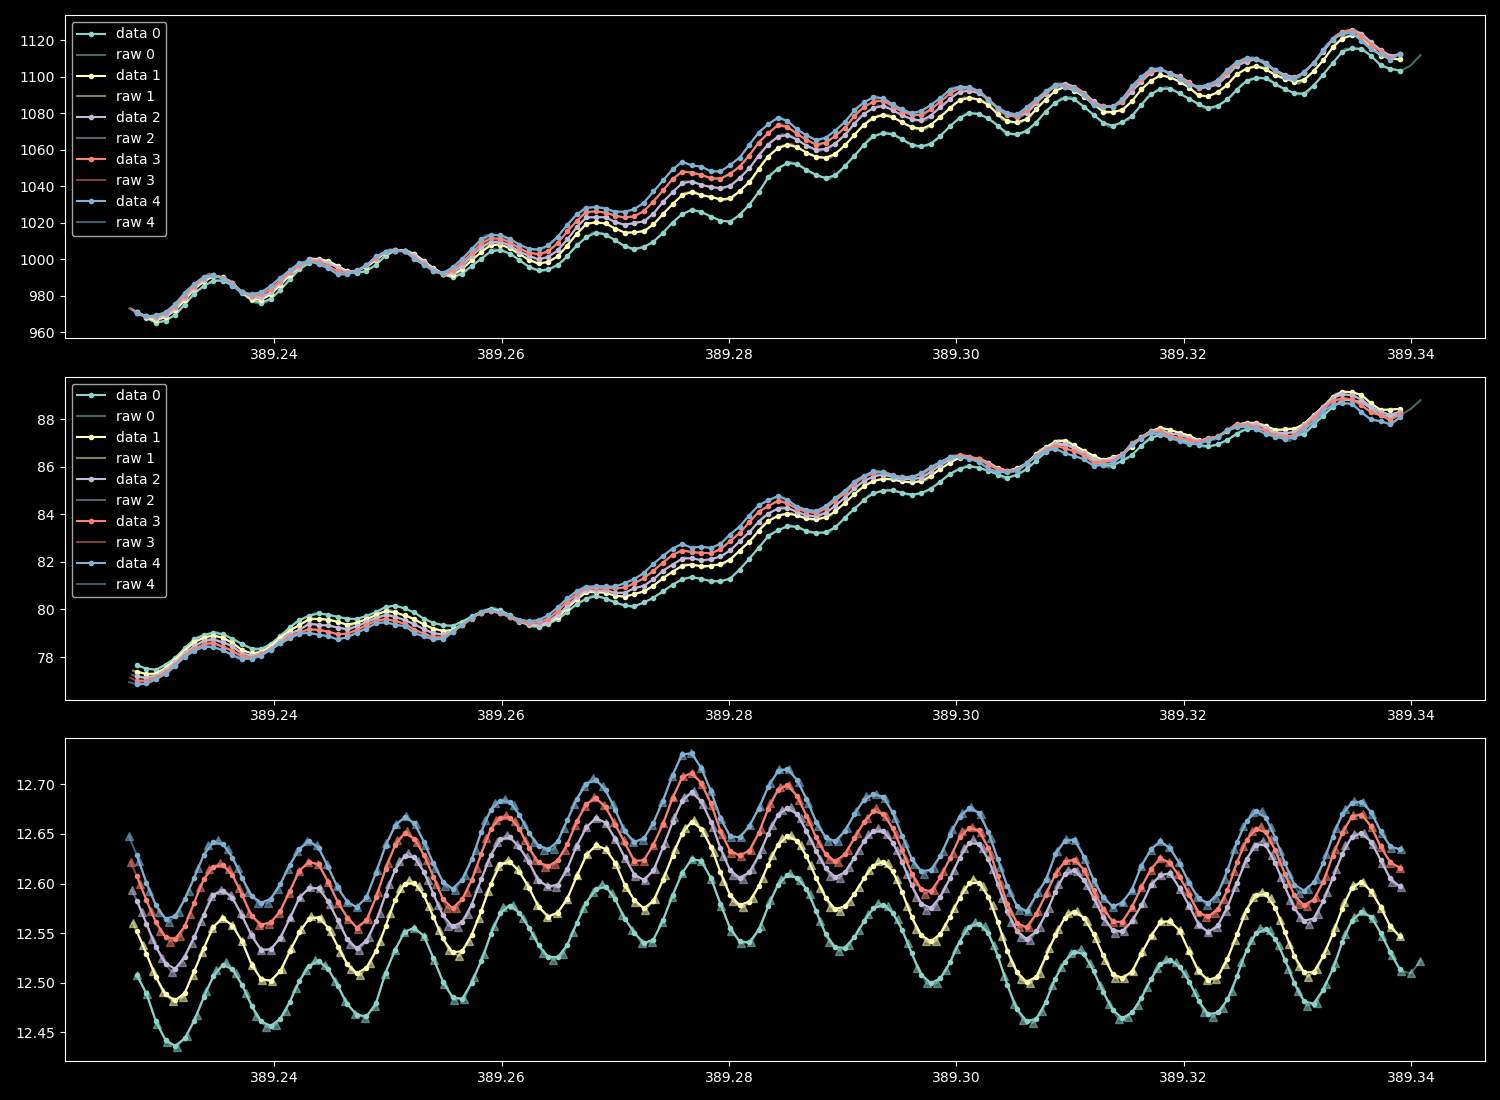

In [21]:
fig, axes = plt.subplots(figsize=(15,11),nrows=3)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]

for i,m in enumerate(data_c):
    ax.plot(common_freq_array.m, trans_interp[i](common_freq_array),label='data ' + str(i), color='C'+str(i), marker='.')
    ax.plot(m['freq'], m['hot'], label='raw ' + str(i), color='C'+str(i), alpha=0.5)
    
    ax1.plot(common_freq_array.m, ref_interp[i](common_freq_array),label='data ' + str(i), color='C'+str(i), marker='.')
    ax1.plot(m['freq'], m['ref'], label='raw ' + str(i), color='C'+str(i), alpha=0.5)
    
    ax2.plot(common_freq_array.m, trans_interp[i](common_freq_array) / ref_interp[i](common_freq_array),label='data ' + str(i), color='C'+str(i), marker='.')
    ax2.plot(m['freq'], m['hot'] / m['ref'], label='raw ' + str(i), color='C'+str(i), alpha=0.5, marker='^')
ax.legend()
ax1.legend()
plt.tight_layout()
plt.show()

### Testing Calibration Curve with data absorption_3 and 4 (5 too but it doesn't really make sense to use it there?)

In [22]:
group = "elsa_2025_07_21/absorption_4"
data = h5t.load_group(outfname, group)
full_scan_md = h5t.get_node_metadata(outfname, group)
full_scan_md

{'misc_notes': 'Calibration curve measurement. hot cell ELSA, two powermeters, and beam sampler. freq and power measurements with WS-7 too.',
 'power_meter_head': 'S121C and S120C',
 'cell_temperature': <Quantity(190, 'degree_Celsius')>,
 'power_meter_wavelength': <Quantity(770, 'nanometer')>,
 'probe_laser_current': <Quantity(55, 'milliampere')>,
 'settling_time_scan': <Quantity(2.5, 'second')>}

In [23]:
xr_bound = -6
hot_freq_array = data['freq'][:xr_bound]

In [24]:
calibration_curve_interp = np.zeros(hot_freq_array.size)
for i,m in enumerate(data_c):
    calibration_curve_interp += trans_interp[i](hot_freq_array) / ref_interp[i](hot_freq_array) / data_c.size

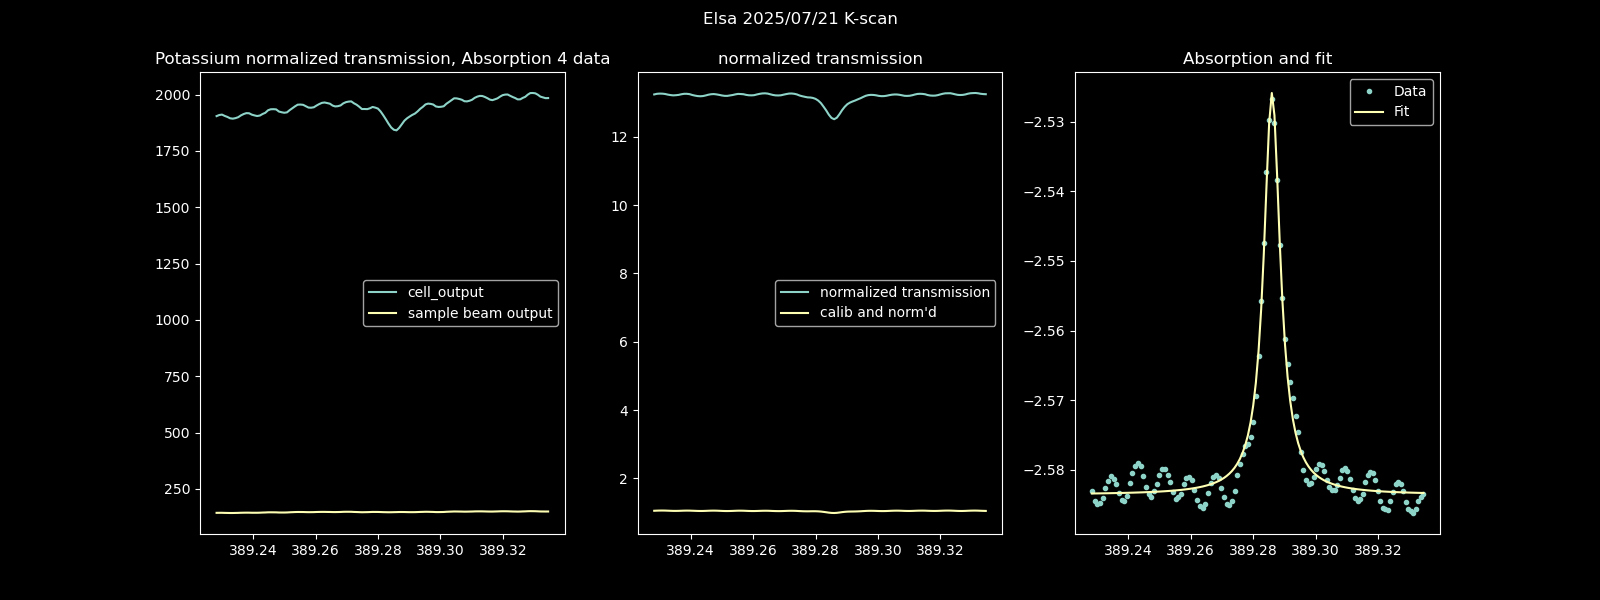

In [25]:
P_hot = data['hot'][:xr_bound]
P_ref = data['ref'][:xr_bound]
x_range = data['freq'][:xr_bound]
x_range_2 = data['fscan_dig'][:xr_bound]

normalized_transmission = P_hot / P_ref

fig, axes = plt.subplots(figsize=(16,6), ncols=3)
ax = axes[0]
ax2 =axes[1]
ax3 = axes[2]
ax.plot(x_range.m, (P_hot).m, label='cell_output')
ax.plot(x_range.m, (P_ref).m,label='sample beam output')
ax2.plot(x_range.m, normalized_transmission, label='normalized transmission')
ax2.plot(x_range.m, normalized_transmission/calibration_curve_interp, label='calib and norm\'d')

logged_transmission = -np.log(normalized_transmission)
abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(x_range.m, logged_transmission.m,guess = [0.07,389.228,0.144,0.05])
fit_result.plot_fit(ax=ax3)

ax.set_title('Potassium normalized transmission, Absorption 4 data')
ax2.set_title('transmission')
ax.legend()
ax2.legend()
plt.suptitle('Elsa 2025/07/21 K-scan')
ax2.set_title('normalized transmission')
ax3.set_title('Absorption and fit')
plt.show()

In [ ]:
#DENSITY CALCULATION
HWHM_temp = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.delta_degC)
c = scipy.constants.c*ureg.m/ureg.s
HWHM_freq = HWHM_temp * freq_per_temp
cross_section_on_resonance = c*rad_e*f_D1/ (HWHM_freq) * -1 #fixing signage
cross_section_on_resonance.to(ureg.cm**2)
L = 1 * ureg.cm
#absorbance_resonance = -np.log(normalized_transmission.min()/normalized_transmission[0])
absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM']
density_K = absorbance_resonance / (L * cross_section_on_resonance)
density_K.to(1/ureg.cm**3)
"{:.3e} 1/cm^3".format(density_K.to(1/ureg.cm**3).m)

# K Scan Olaf 25/07/2025 with calibration curve

In [ ]:
#h5t.delete_dataset(outfname, "olaf_2025_07_25/K/calibration_curve_4")

In [ ]:
#loading up 6 scans of calibration data
data1 = h5t.load_group(outfname, "olaf_2025_07_25/K/calibration_curve_1") #weird phase delay
data2 = h5t.load_group(outfname, "olaf_2025_07_25/K/calibration_curve_2") #weird phase delay
data3 = h5t.load_group(outfname, "olaf_2025_07_25/K/calibration_curve_3") #weird phase delay
data4 = h5t.load_group(outfname, "olaf_2025_07_25/K/calibration_curve_4") #bad data
data5 = h5t.load_group(outfname, "olaf_2025_07_25/K/calibration_curve_5") #weird phase delay
data6 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_6")
data7 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_7")
data8 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_8")
data9 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_9")
data10 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_10")
data11 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_11") #bad data
data12 = h5t.load_group(outfname, "olaf_2025_07_28/K/calibration_curve_12")
data13 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_13")
data14 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_14")
data15 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_15")
data16 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_16")
data17 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_17")
data18 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_18")
data19 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_19")
data20 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_20")
data21 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_21")
data22 = h5t.load_group(outfname, "olaf_2025_07_29/K/calibration_curve_22")
data23 = h5t.load_group(outfname, "olaf_2025_07_31/K/calibration_curve_23")
data24 = h5t.load_group(outfname, "olaf_2025_07_31/K/calibration_curve_24")
data25 = h5t.load_group(outfname, "olaf_2025_07_31/K/calibration_curve_25")

data_c = np.array([data1,data2,data3, data4, data5,data6,data7,data8,data9,data10,data11,data12,data13,data14,data15,data16,data17,data18,data19,data20,data21,data22,data23,data24,data25])
#data_c = np.array([data6,data7,data8,data9,data10,data11,data12])
h5t.get_node_metadata(outfname, "olaf_2025_07_25/K/calibration_curve_5")

In [ ]:
#selecting the largest minimum and smallest maximum so that interpolator is within range of all data
f_min = data_c[max(np.arange(data_c.size), key = lambda i: data_c[i]['freq'][-1])]['freq'][-1]
f_max =data_c[min(np.arange(data_c.size), key = lambda i: data_c[i]['freq'][0])]['freq'][0]

#assuming a common x-range for now
num_steps = 200
common_freq_array = np.linspace(f_min, f_max, num_steps)

#defining reference and transmission interpolators
ref_interp = [None] * data_c.size
trans_interp = [None] * data_c.size
for i, data_set in enumerate(data_c):
    ref_interp[i] = scipy.interpolate.interp1d(data_set['freq'].m, data_set['ref'].m, kind = 'linear')
    trans_interp[i] = scipy.interpolate.interp1d(data_set['freq'].m, data_set['hot'].m, kind = 'linear')

In [ ]:
fig, axes = plt.subplots(figsize=(13,13),nrows=3)
ax, ax1, ax2 = axes

#defining a average caibration curve of assumed length
calib_avg = common_freq_array.m*0

for i,m in enumerate(data_c):
    #omitting bad data
    omit_data = np.array([3,10])
    if (np.isin(i,omit_data)):
        continue
        
    #plotting transmission power
    ax.plot(common_freq_array.m, trans_interp[i](common_freq_array),label='data ' + str(i), color='C'+str(i), marker='.')
    ax.plot(m['freq'], m['hot'], color='C'+str(i), alpha=0.5)
    #plotting reference power
    ax1.plot(common_freq_array.m, ref_interp[i](common_freq_array),label='data ' + str(i), color='C'+str(i), marker='.')
    ax1.plot(m['freq'], m['ref'], color='C'+str(i), alpha=0.5)
    #plotting calibration curves
    ax2.plot(common_freq_array.m, trans_interp[i](common_freq_array) / ref_interp[i](common_freq_array), color='C'+str(i), marker='.',alpha=0.3)
    #ax2.plot(m['freq'], m['hot'] / m['ref'], color='C'+str(i), alpha=0.5, marker='^')
    #defining average calibration
    calib_avg += trans_interp[i](common_freq_array) / ref_interp[i](common_freq_array) / (data_c.size - omit_data.size) 
    
ax2.plot(common_freq_array.m, calib_avg,linewidth=3,label='average calibration curve')

plt.suptitle('Average Calibration curve of 25 Cold Cell Scans across 6 days')
ax.set_title('Transmission')
ax1.set_title('Reference')
ax2.set_title('Calibration Curves (transmission / reference)')
ax1.set_ylabel('Power [uW]')
ax.set_ylabel('Power [uW]')
ax2.legend()
ax2.set_xlabel('Frequency [THz]')
plt.tight_layout()
plt.show()

In [ ]:
h5t.get_node_metadata(outfname,"olaf_2025_07_29/K/absorption_11")

In [ ]:
fig, axes = plt.subplots(nrows=4,figsize=(13,16))

ax0, ax1, ax2,ax3 = axes
ax01 = ax0.twinx()

data1=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_1")
data2=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_2")
data3=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_3") #jumping but usable data
data4=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_4")
data5=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_5") #jumpnig but usable data
data6=h5t.load_group(outfname,"olaf_2025_07_28/K/absorption_6") #bad data, remove when at like 100 degC
data7=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_7")
data8=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_8") #lights off
data9=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_9") #magnetic bias and lights back on
data10=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_10") #double the amount of points and magnetic bias off
data11=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_11") #bad data, remove
data12=h5t.load_group(outfname,"olaf_2025_07_29/K/absorption_12")
data_h = np.array([data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12])
#data_h = np.array([data4])
ax0_lns = []
ax1_lns = []
#omit_data = np.array([0,1,2,3,4,5,7,8,9,10,11])
omit_data = np.array([2,4,5,10])
data_density = np.zeros(data_h.size)
data_hwhm = np.zeros(data_h.size)
data_f0 = np.zeros(data_h.size)

for i,data_h_m in enumerate(data_h):
    if (np.isin(i,omit_data)):
        continue
    mask = (data_h_m['freq'].m>389.23) * (data_h_m['freq'].m<389.338)
    freq = data_h_m['freq'][mask]
    output = data_h_m['hot'][mask]
    ref = data_h_m['ref'][mask]
    
    #calculate the average calibration curve my interpolating based on x-axis of hot scan
    calib_avg = freq.m * 0
    for j,m in enumerate(data_c):
        calib_avg += trans_interp[j](freq) / ref_interp[j](freq)/(data_c.size)
    
    #RAW TRANSMISSION PLOT
    ln1 = ax0.plot(freq, output, marker='.', label='trans ' + str(i), color='C'+str(i))
    ln2 = ax01.plot(freq, ref, label='ref ' + str(i),color='C'+str(i),alpha=0.5)
    ax0_lns += ln1
    
    #NORMALIZED PLOT
    ln3 = ax1.plot(freq, output/ref, marker='.', label='trans/ref ' + str(i), color='C'+str(i))
    #ln4 = ax1.plot(freq, calib_avg, marker='.', label='calib' + str(i), color='C'+str(i))
    ax1_lns += ln3 
    
    #CALIBRATED PLOT
    ln4 = ax2.plot(freq, output/ref/calib_avg, label='trans/ref/calib ' + str(i), color = 'C' + str(i))
    
    #ABS PLOT
    normalized_transmission = output/ref/calib_avg
    ln5 = ax3.plot(freq, -np.log((normalized_transmission)), color='C'+str(i),alpha=0.6)
    
    abs_fitter =fitt.AbsorptiveLorentzianFitter()
    fit_result = abs_fitter.fit(freq.m, -np.log(normalized_transmission).m,guess = [0.07,389.228,0.144,0.05])
    A = fit_result.fit_parameters['A']
    f0 = fit_result.fit_parameters['f0']
    HWHM = fit_result.fit_parameters['HWHM']
    Offset = fit_result.fit_parameters['Offset']
    
    #DENSITY CALCULATION
    HWHM_freq = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.THz)
    c = scipy.constants.c*ureg.m/ureg.s
    cross_section_on_resonance = c*rad_e*f_D1/ (HWHM_freq)
    cross_section_on_resonance.to(ureg.cm**2)
    L = 1 * ureg.cm
    #absorbance_resonance = -np.log(normalized_transmission.min() / normalized_transmission.max()) #close approximation but better to work with the fit rather than the data.
    #absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM'] #do not include offset, as that isnt physical.
    absorbance_resonance = (A / HWHM) - A * HWHM / (f0**2 + HWHM**2) #small minor negligble change, consider as log(P/P0) on resonance minus log(P/P0) off resonance
    density_K = absorbance_resonance / (L * cross_section_on_resonance)
    data_density[i] = density_K.to(1/ureg.cm**3).m
    data_hwhm[i] = HWHM
    data_f0[i] = f0
 
    fit_result.plot_fit(ax=ax3,dkwargs={"color":'C' + str(i), "alpha":0.1, "label":'_nolegend_'},
                        fkwargs={"color":'C' + str(i), "label":"rho_k = {:.3e}\nr2 = {:.3}".format(density_K.to(1/ureg.cm**3).m,fit_result.r2)})
    
ax0.legend(ax0_lns, [l.get_label() for l in ax0_lns], loc = 0)
ax1.legend(ax1_lns, [l.get_label() for l in ax1_lns], loc = 0)
ax0.set_title('Raw transmission scan w/ translucent raw reference scans')
ax1.set_title('transmission / reference scans')
ax0.set_ylabel('power [uW]')
ax1.set_ylabel('norm trans')
ax2.set_title('normalized transmission w/ calibration')
ax3.set_ylabel('absorption')
plt.setp(axes,xlabel='frequency [THz]')
plt.tight_layout()
plt.show()

In [54]:
data_f0[data_f0 > 0].mean()*ureg.THz

<Quantity(389.284287, 'terahertz')>

In [57]:
data_f0[data_f0 > 0].std()*ureg.THz

<Quantity(6.79914101e-05, 'terahertz')>

In [60]:
(data_hwhm[data_hwhm > 0].mean() * ureg.THz)

<Quantity(4.85583234, 'gigahertz')>

In [61]:
(data_hwhm[data_hwhm > 0].std() * ureg.THz).to(ureg.GHz)

<Quantity(0.21859539, 'gigahertz')>

In [13]:
print('density = {:.3e}'.format((data_density[data_density > 0]).mean()))

density = 3.786e+11


In [14]:
(data_density[data_density > 0].mean() / ureg.cm**3)

<Quantity(3.78608468e+11, '1 / centimeter ** 3')>

In [65]:
x_temp = data24['freq']
y_temp = data24['fscan_dig']

In [66]:
fit_result = fitt.fit_line(x_temp, y_temp)

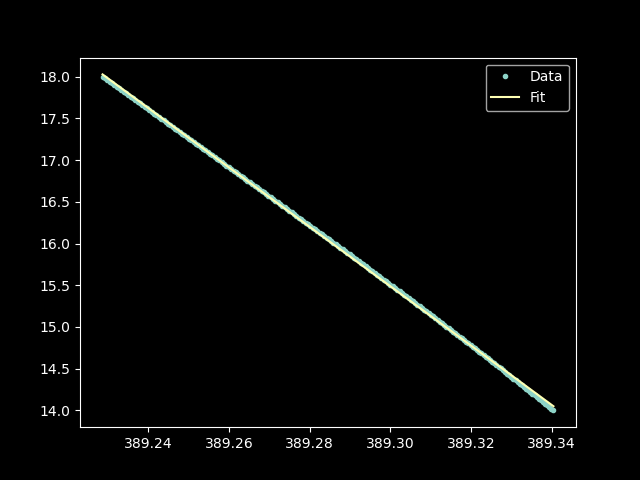

In [67]:
fig, ax = plt.subplots()
fit_result.plot_fit()
plt.show()

In [68]:
slope_temp = fit_result.fit_parameters['slope'].m *ureg.delta_degC / ureg.THz

In [69]:
slope_temp * data_f0[data_f0 > 0].mean()*ureg.THz + fit_result.fit_parameters['intercept']

<Quantity(16.0484736, 'degree_Celsius')>

In [79]:
m = (fit_result.fit_parameters['slope'].m * ureg.delta_degC/ureg.THz)

In [80]:
b = (fit_result.fit_parameters['intercept'].m * ureg.delta_degC)

In [100]:
(m*x).to(ureg.delta_degC)

<Quantity(-0.341561727, 'delta_degree_Celsius')>

In [104]:
85/17

5.0

In [113]:
(16.048 + 0.85 + .17)

17.068

In [99]:
x =  2*4.8*ureg.GHz
deg_estim = m*x + b
deg_estim - 16.048*ureg.delta_degC

<Quantity(13850139.4, 'delta_degree_Celsius * gigahertz / terahertz')>

# Rb Scan Elsa 23/07/2025 (fine) [GOOD BUT NOT FULL PICTURE]

In [ ]:
group_name = "elsa_2025_07_23/rb/hot_scan"
data = h5t.load_group(outfname, group_name)
x_range = data['freq']

error_mask = x_range.m>700

In [ ]:
fig, axes = plt.subplots(figsize=(15,8),nrows=2)
ax = axes[0]
ax1 = axes[1]
group_name = "elsa_2025_07_23/rb/cold_scan"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

ax2 = ax.twinx()
gain_calib = P_hot[0]/ P_ref[0]

lns1 = ax.plot(x_range.m, P_hot.m, label='Output power', marker='.')
lns2 = ax.plot(x_range.m, (P_ref*gain_calib), label='Reference power', marker='.')
lns3 = ax2.plot(x_range.m, P_hot/(P_ref*gain_calib), color='C3', label='transmission', marker='.' )

calibration_curve = P_hot/P_ref/gain_calib

group_name = "elsa_2025_07_23/rb/hot_scan"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

ax3 = ax1.twinx()
ain_calib = P_hot[0]/ P_ref[0]

lns1 = ax1.plot(x_range.m, P_hot.m, label='Output power', marker='.')
lns2 = ax1.plot(x_range.m, (P_ref*gain_calib), label='Reference power', marker='.')
lns3 = ax3.plot(x_range.m, P_hot/(P_ref*gain_calib)/calibration_curve, color='C3', label='transmission' , marker='.')

ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('Power [uW]')
ax2.set_ylabel('Transmission')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.suptitle('23/07/2025 ELSA Rb transmission, coarse scan')
plt.show()

# Rb Scan Elsa 23/07/2025 (coarse) [BEST]

In [ ]:
h5t.get_node_metadata(outfname, group_name)

In [ ]:
group_name = "elsa_2025_07_23/rb/hot_scan_large"
data = h5t.load_group(outfname, group_name)
x_range = data['freq']

error_mask = x_range.m>700
x_range = data['freq'][error_mask]

mask_ranges = np.array([(-100,710.788),
          (710.826,710.851),
          (710.885,710.906),
          (710.996,711.017),
          (711.050,711.074),
          (711.105,711.129),
          (711.164,800)])

fit_mask = x_range.m > -10000
for i,m in enumerate(mask_ranges):
    L = x_range.m > m[0]
    R = x_range.m < m[1]
    fit_mask *= ~(L*R)

In [ ]:
fig, axes = plt.subplots(figsize=(15,14),nrows=4)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]
ax3 = axes[3]

#COLD SCAN
group_name = "elsa_2025_07_23/rb/cold_scan_large"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

ax00 = ax.twinx()
first_valid_point = np.where(x_range.m == x_range.m[fit_mask][0])
gain_calib = P_hot[first_valid_point]/ P_ref[first_valid_point]

lns1 = ax.plot(x_range.m, P_hot.m, label='Power out', marker='.')
lns2 = ax.plot(x_range.m, (P_ref*gain_calib), label='Power ref', marker='.')
lns3 = ax00.plot(x_range.m, P_hot/(P_ref*gain_calib), color='C3', label='Calibration', marker='.' )

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

calibration_curve = P_hot/P_ref/gain_calib

#HOT SCAN
group_name = "elsa_2025_07_23/rb/hot_scan_large"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

ax01 = ax1.twinx()
first_valid_point = np.where(x_range.m == x_range.m[fit_mask][0])
gain_calib = P_hot[first_valid_point]/ P_ref[first_valid_point]

lns1 = ax1.plot(x_range.m, P_hot.m, label='Power out', marker='.')
lns2 = ax1.plot(x_range.m, (P_ref*gain_calib), label='Power ref', marker='.')
lns3 = ax01.plot(x_range.m, P_hot/(P_ref*gain_calib)/calibration_curve, color='C3', label='transmission' , marker='.')

#MASK'd SCAN TRANSMISSION
normalized_curve = P_hot/(P_ref*gain_calib)/calibration_curve
lns1 = ax2.plot(x_range.m[fit_mask], normalized_curve[fit_mask] , marker='.',color='C3')

#CONVERTING TO ABSORPTION AND FITTING
#lns1 = ax3.plot(x_range.m[fit_mask], -np.log(normalized_curve[fit_mask]), marker='.')
abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(x_range.m[fit_mask], -np.log(normalized_curve[fit_mask]).m,guess = [0.07,710,0.015,0.05])
fit_result.plot_fit(ax=ax3)


ax3.set_xlabel('Frequency [THz]')
ax.set_ylabel('Power [uW]')
ax1.set_ylabel('Power [uW]')
ax00.set_ylabel('Normalized Transmission',color='C3')
ax01.set_ylabel('Normalized Transmission',color='C3')
ax2.set_ylabel('Transmission')
ax3.set_ylabel('Absorption')
ax.set_title('Cold Scan, gain matched, data')
ax1.set_title('Hot Scan, gain matched and cold-calibrated data')
ax2.set_title('Removing problematic points')

ax.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax1.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax2.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax3.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)


#DENSITY CALCULATION
HWHM_freq = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.THz)
c = scipy.constants.c*ureg.m/ureg.s
f_rb = 0.004 #according to NIST and chatGPT
cross_section_on_resonance = c*rad_e*f_rb/ (HWHM_freq)  #fixing signage
L = 11.87 * ureg.mm
absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM']
density_K = absorbance_resonance / (L * cross_section_on_resonance)

ax3.set_title('Absorption fitting --- Rb Density estimation = {:.3e} 1/cm^3'.format(density_K.to(1/ureg.cm**3).m))
plt.suptitle(group_name,fontsize=20)
plt.tight_layout()
plt.show()

# Rb Scan Olaf 25/07/2025 [best]

In [7]:
group_name = "olaf_2025_07_25/rb/hot_scan"
data = h5t.load_group(outfname, group_name)
x_range = data['freq']

#filtering out x_range error points, there is none in this dataset
error_mask = x_range.m>-700
x_range = data['freq'][error_mask]

mask_ranges = np.array([(710.783,710.790)])
#mask_ranges = np.array([(-100,710.788),
#          (710.826,710.851),
#          (710.885,710.906),
#          (710.996,711.017),
#          (711.050,711.074),
#          (711.105,711.129),
#          (711.164,800)])

#initializing a mask that allows all points except for the regions denoted in the mask_range. 
fit_mask = x_range.m > -10000
for i,m in enumerate(mask_ranges):
    L = x_range.m > m[0]
    R = x_range.m < m[1]
    fit_mask *= ~(L*R)
    
h5t.get_node_metadata(outfname, group_name)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'data/hybrid_pumping.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

C:\Users\labuser_L213\miniforge3\envs\one_ring\lib\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


710.9616495754816
0.015336341358980104


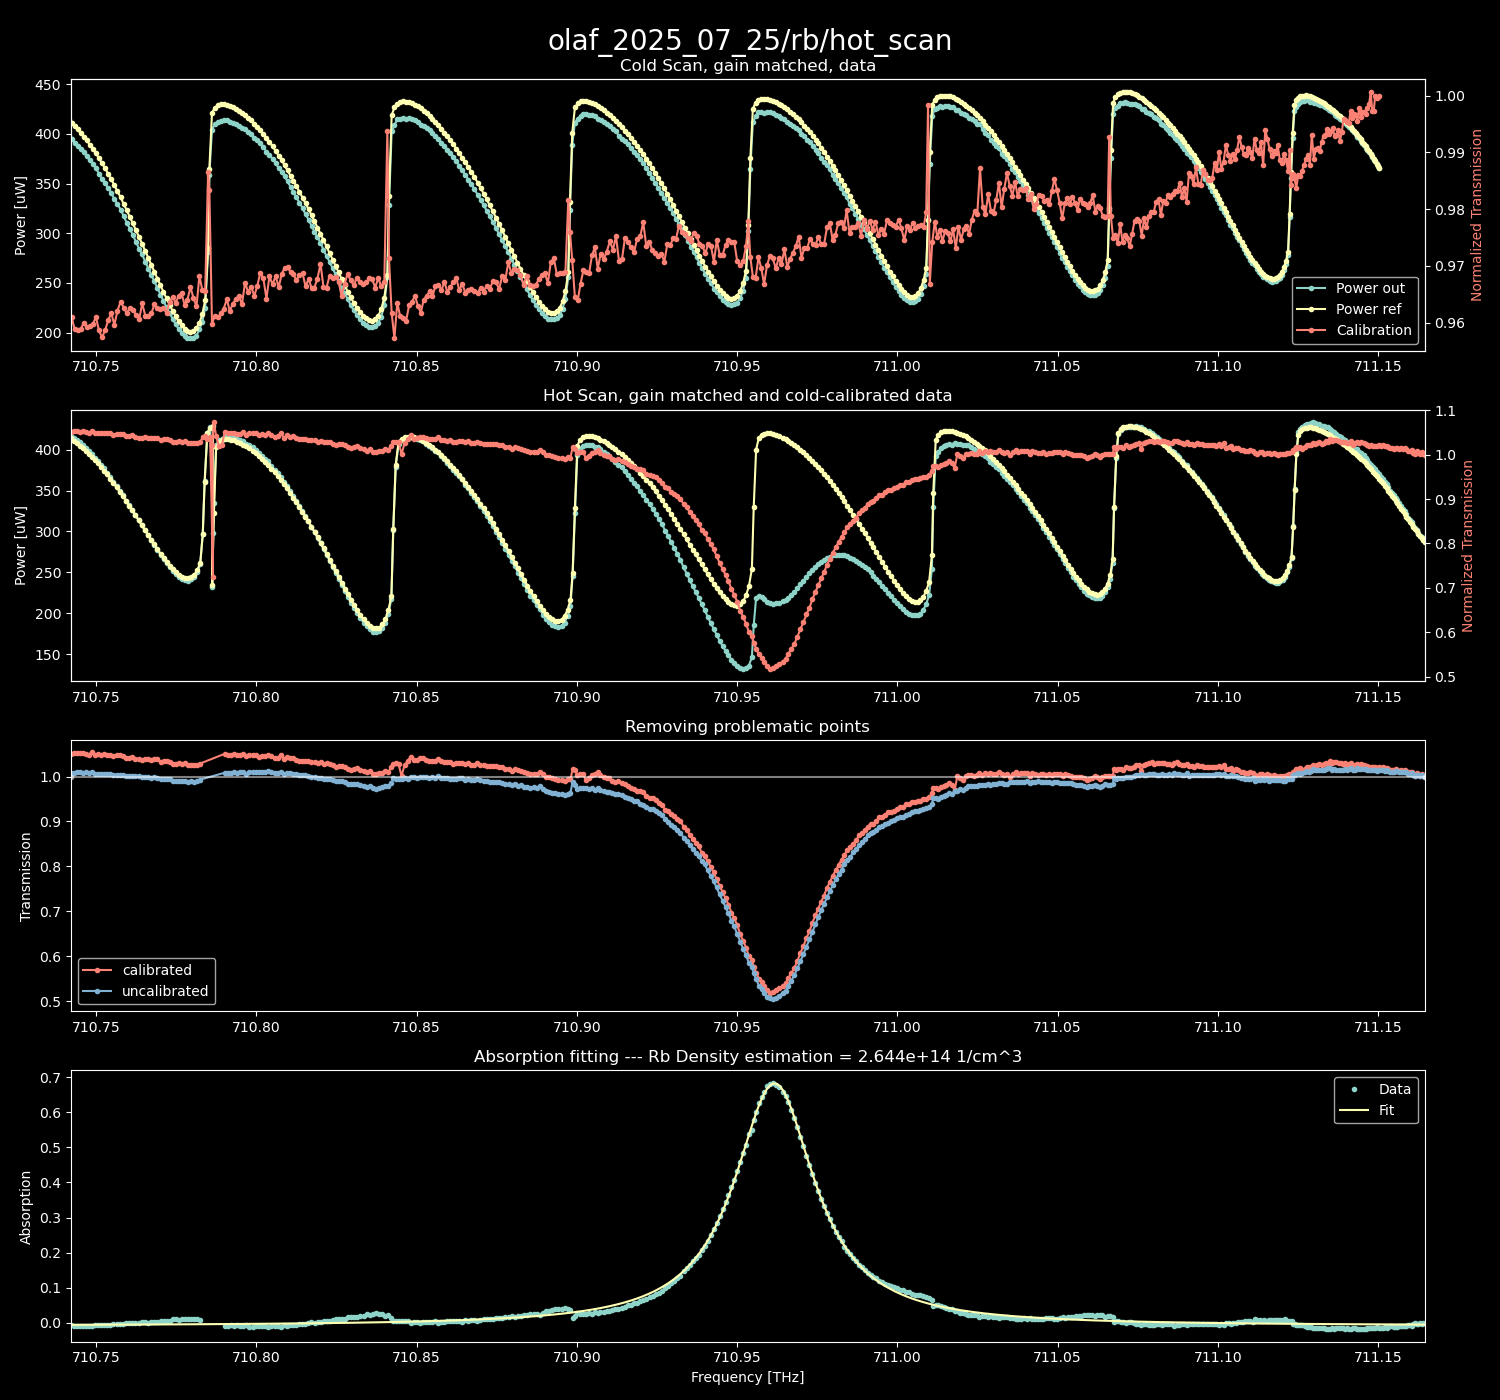

In [5]:
fig, axes = plt.subplots(figsize=(15,14),nrows=4)
ax = axes[0]
ax1 = axes[1]
ax2 = axes[2]
ax3 = axes[3]

#COLD SCAN to get calibration curve--------------------------------
group_name = "olaf_2025_07_25/rb/cold_scan"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

ax00 = ax.twinx()
first_valid_point = np.where(x_range.m == x_range.m[fit_mask][0])
gain_calib = P_hot[first_valid_point] / P_ref[first_valid_point]

lns1 = ax.plot(x_range.m, P_hot.m, label='Power out', marker='.')
lns2 = ax.plot(x_range.m, (P_ref*gain_calib), label='Power ref', marker='.')
lns3 = ax00.plot(x_range.m, P_hot/(P_ref*gain_calib), color='C3', label='Calibration', marker='.' )

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

calibration_curve = P_hot/P_ref/gain_calib

#HOT SCAN---------------------------------------------------------
group_name = "olaf_2025_07_25/rb/hot_scan"
data = h5t.load_group(outfname, group_name)
P_hot = data['P_hot'][error_mask]
P_ref = data['P_ref'][error_mask]
x_range = data['freq'][error_mask]

ax01 = ax1.twinx()
first_valid_point = np.where(x_range.m == x_range.m[fit_mask][0])
gain_calib = P_hot[first_valid_point]/ P_ref[first_valid_point]

lns1 = ax1.plot(x_range.m, P_hot.m, label='Power out', marker='.')
lns2 = ax1.plot(x_range.m, (P_ref*gain_calib), label='Power ref', marker='.')
lns3 = ax01.plot(x_range.m, P_hot/(P_ref*gain_calib)/calibration_curve, color='C3', label='transmission' , marker='.')

#MASK'd SCAN TRANSMISSION
normalized_curve = P_hot/(P_ref*gain_calib)
lns1 = ax2.plot(x_range.m[fit_mask], normalized_curve[fit_mask] / calibration_curve[fit_mask] , label='calibrated', marker='.',color='C3')
lns2 = ax2.plot(x_range.m[fit_mask], normalized_curve[fit_mask], color='C4', label='uncalibrated', marker='.')
lns3 = ax2.axhline(1,alpha=0.5, marker = '.')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

#CONVERTING TO ABSORPTION AND FITTING
#lns1 = ax3.plot(x_range.m[fit_mask], -np.log(normalized_curve[fit_mask]), marker='.')
abs_fitter =fitt.AbsorptiveLorentzianFitter()
fit_result = abs_fitter.fit(x_range.m[fit_mask], -np.log(normalized_curve[fit_mask]).m,guess = [0.07,710.96,0.035,0.00])
fit_result.plot_fit(ax=ax3)
print(fit_result.fit_parameters['f0'])
print(fit_result.fit_parameters['HWHM'])


ax3.set_xlabel('Frequency [THz]')
ax.set_ylabel('Power [uW]')
ax1.set_ylabel('Power [uW]')
ax00.set_ylabel('Normalized Transmission',color='C3')
ax01.set_ylabel('Normalized Transmission',color='C3')
ax2.set_ylabel('Transmission')
ax3.set_ylabel('Absorption')
ax.set_title('Cold Scan, gain matched, data')
ax1.set_title('Hot Scan, gain matched and cold-calibrated data')
ax2.set_title('Removing problematic points')

ax.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax1.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax2.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)
ax3.set_xlim(left=data['freq'][-1].m,right=data['freq'][0].m)


#DENSITY CALCULATION
HWHM_freq = ureg.Quantity(fit_result.fit_parameters['HWHM'],ureg.THz)
c = scipy.constants.c*ureg.m/ureg.s
f_rb = 0.004 #according to NIST and chatGPT
cross_section_on_resonance = c*rad_e*f_rb/ (HWHM_freq)  #fixing signage
L = 11.87 * ureg.mm
absorbance_resonance = fit_result.fit_parameters['A'] / fit_result.fit_parameters['HWHM']
density_K = absorbance_resonance / (L * cross_section_on_resonance)

ax3.set_title('Absorption fitting --- Rb Density estimation = {:.3e} 1/cm^3'.format(density_K.to(1/ureg.cm**3).m))
plt.suptitle(group_name,fontsize=20)
plt.tight_layout()
plt.show()

In [100]:
f0 = 710.9616495754816 * ureg.THz

In [94]:
data['freq'].shape

(500,)

In [136]:
x_temp = np.linspace(-5,5,500) * ureg.V
y_temp = x_range

In [137]:
fit_result = fitt.fit_line( y_temp, x_temp)

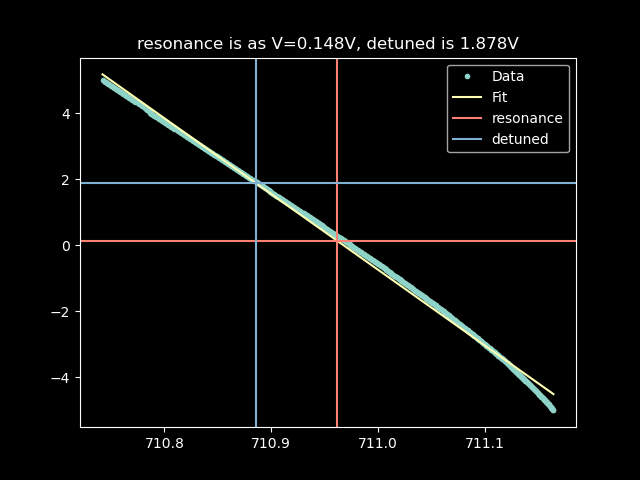

In [150]:
fig,ax = plt.subplots()
fit_result.plot_fit()
ax.axvline(710.9616495754816,color='C3', label='resonance')
ax.axhline(0.14762706197143416,color='C3')
ax.axvline(710.9616495754816 -0.07542412680346415,color='C4', label='detuned')
ax.axhline(1.8776862013128266,color='C4')
ax.legend()
plt.title('resonance is as V=0.148V, detuned is 1.878V')
plt.show()

In [144]:
detuned_f0 = (710.9616495754816 -0.07542412680346415)*ureg.THz

In [145]:
fit_result.fit_parameters['slope'] * detuned_f0 + fit_result.fit_parameters['intercept']

<Quantity(1.8776862, 'volt')>